In [261]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
cs = [colours[i] for i in range(len(colours))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [72]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [73]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [74]:
for route in routes:
    add_extra_data(route)

In [75]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [325]:
new_6 = pd.read_csv("data/6 09-06-20.csv")
new_52 = pd.read_csv("data/52 09-06-20.csv")
new_9 = pd.read_csv("data/9 09-06-20.csv")

new_6.head()

,vehicle_id,bus_stop_id,time_of_arrival,time_of_req,direction
0,10623_490003256N_2020-05-17_inbound_0,490003256N,2020-05-17 17:19:04,2020-05-17 17:19:17.892,inbound
1,10623_490006108E_2020-05-17_inbound_0,490006108E,2020-05-17 17:20:01,2020-05-17 17:19:24.951,inbound
2,10636_490006471E_2020-05-17_outbound_0,490006471E,2020-05-17 17:19:30,2020-05-17 17:19:27.03,outbound
3,10285_490013046M_2020-05-17_outbound_0,490013046M,2020-05-17 17:19:58,2020-05-17 17:19:36.662,outbound
4,11485_490000186A_2020-05-17_inbound_0,490000186A,2020-05-17 17:20:09,2020-05-17 17:19:37.928,inbound


In [76]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

In [289]:
stops_452 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_452.csv")
stops_52 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_52.csv")
stops_7 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_7.csv")
stops_14 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_14.csv")
stops_9 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_9.csv")
stops_328 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_328.csv")
stops_69 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_69.csv")
stops_35 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_35.csv")
stops_37 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_37.csv")
stops_267 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_267.csv")
stops_277 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_277.csv")
stops_6 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_6.csv")

stops = {}
stops["452"] = stops_452
stops["52"] = stops_52
stops["7"] = stops_7
stops["9"] = stops_9
stops["14"] = stops_14
stops["328"] = stops_328
stops["267"] = stops_267
stops["277"] = stops_277
stops["35"] = stops_35
stops["37"] = stops_37
stops["69"] = stops_69
stops["6"] = stops_6

In [347]:
tfl_predictions = pd.read_csv("data-collection/tfl preds/tfl_predictions.csv")
tfl_predictions.head()

,start_stop,end_stop,time_of_req,pred_jrny_time
0,Willesden Bus Garage,Okehampton Road,2020-06-01 14:45:00+00:00,0:07:39
1,Willesden Bus Garage,Harrow Road / Kilburn Lane,2020-06-01 14:45:00+00:00,0:11:41
2,Willesden Bus Garage,Chesterton Road,2020-06-01 14:45:00+00:00,0:17:52
3,Willesden Bus Garage,Notting Hill Gate Station,2020-06-01 14:45:00+00:00,0:25:13
4,Chesterton Road,Notting Hill Gate Station,2020-06-01 14:45:00+00:00,0:07:21


# Data Analytics

## Helper Functions

In [160]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [164]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

In [309]:
# Generate list of request times at minutes interval
def generate_request_times(minutes, start, end):
    """
    minutes: frequency of request times e.g. every 15 minutes
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    start = convert_time_to_datetime(start)
    end = convert_time_to_datetime(end)
    req_times = [start]
    
    while start <= end:
        new_time = start + dt.timedelta(minutes = minutes)
        req_times.append(new_time)
        start = new_time
        
    format = '%Y-%m-%d %H:%M:%S'
    req_times_str = [t.strftime(format) for t in req_times]
    return req_times_str

## Predict journey time by taking recent information into account 

### Route 52 Gap of 5: Chesterton Road to Nottinghill Gate Station (inbound)

I am at Chesterton Road and I want to know how long it will take my bus to get to Nottinghill Gate Station. The current time is X.

1) **Looking back different amounts of time**

- I look at the other buses that have left Chesterton Road and arrived at Nottinghill Gate Station in the past x hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes. (Obviously depends on how far back we look, between 15 minutes to 2 hours). Then calculate this weighted average as the predicted journey time for a bus travelling between Chesterton Road and Nottinghill Gate. **predicted journey time = weighted average of past x hours of journey times**

2) **Looking back different numbers of buses**

- I look at the past x buses that have left Chesterton Road and arrived at Nottinghill Gate Station. Weight it so that the journey times for the more recent buses weight more than the journey times of the less recent buses. What counts as 'recent' depends on how many buses back we are looking.

I look for the last bus to leave Chesterton Road and arrive at Nottinghill Gate before the request time. Then I get the next immediate bus that leaves Chesterton Road. This is the one that will be used to predict the arrival time. Add the predicted journey time onto the leave time of this bus + 30 seconds loading/unloading time to get the predicted arrival time. **predicted arrival time = leave time + predicted journey time + 30 seconds**. 

If such a bus doesn't exist, then there is no predicted arrival time, but there is still the predicted journey time. E.g. if I request the time that the nearest bus will arrive at Nottinghill Gate at 03:16:27, then I gather all the buses that arrived at Nottinghill Gate within the past 2 hours that arrived BEFORE 03:16:27. Say the last bus that left Chesterton Road left at 02:45 and arrived at Nottinghill Gate at 03:15. So to get the predicted arrival time, I try to find the next bus to leave Chesterton Road, which is a bus that leaves at 03:17. This time is AFTER the request time so I cannot use this bus in the prediction because it is not the historical data.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

I now get the actual arrival time. The same bus that we used to calculate the predicted arrival time, we track its vehicle id in the entries for Nottinghill Gate and look for its actual arrival time. Get the actual journey time by subtracting the leave time from the actual arrival time. **actual journey time = actual arrival time - leave time**

To evaluate success, plot the predicted journey journey time against the actual journey time and could calculate the MAPE or something along those lines.

In [189]:
stop_a_name52 = stops_in_sequence_inbound.get("52")[16]
stop_b_name52 = stops_in_sequence_inbound.get("52")[21]

print(stop_a_name52, stops_in_sequence_inbound.get("52").index("Chesterton Road"))
print(stop_b_name52, stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

Chesterton Road 16
Notting Hill Gate Station 21


In [332]:
temp_52_a = new_52.loc[(new_52['bus_stop_id'] == '490005139C') & (new_52['direction'] == 'inbound')]
temp_52_a['bus_stop_name'] = "Chesterton Road"
temp_52_a = temp_52_a.drop(columns = "bus_stop_id")

temp_52_b = new_52.loc[(new_52['bus_stop_id'] == '490000167G') & (new_52['direction'] == 'inbound')]
temp_52_b['bus_stop_name'] = "Notting Hill Gate Station"
temp_52_b = temp_52_b.drop(columns = "bus_stop_id")

temp_52_b.head()

/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,vehicle_id,time_of_arrival,time_of_req,direction,bus_stop_name
25,19399_490000167G_2020-05-17_inbound_0,2020-05-17 05:56:51,2020-05-17 05:55:46.856,inbound,Notting Hill Gate Station
102,19673_490000167G_2020-05-17_inbound_0,2020-05-17 06:09:08,2020-05-17 06:08:59.781,inbound,Notting Hill Gate Station
173,19391_490000167G_2020-05-17_inbound_0,2020-05-17 06:21:30,2020-05-17 06:04:35.092,inbound,Notting Hill Gate Station
227,11530_490000167G_2020-05-17_inbound_0,2020-05-17 06:31:55,2020-05-17 06:22:05.661,inbound,Notting Hill Gate Station
270,10267_490000167G_2020-05-17_inbound_0,2020-05-17 06:40:32,2020-05-17 06:37:50.207,inbound,Notting Hill Gate Station


In [342]:
b_52 = data["52"]

stop_a52 = b_52.loc[(b_52['bus_stop_name'] == stop_a_name52) & (b_52['direction'] == 'inbound')]

xid = stops_52.loc[(stops_52['stop_name'] == stop_a_name52) & (stops_52['direction'] == 'inbound')]
xid = xid.get('stop_id').values[0]
print("inbound id: ", xid)

[_, stop_a_id52, _, _, _] = stop_a52.iloc[0]['vehicle_id'].split('_')
print(stop_a52.shape)
print("found id: ", stop_a_id52)
stop_a52 = temp_52_a
stop_a52.head()

inbound id:  490005139C
(1351, 5)
found id:  490005139C


,vehicle_id,time_of_arrival,time_of_req,direction,bus_stop_name
7,19399_490005139C_2020-05-17_inbound_0,2020-05-17 05:52:05,2020-05-17 05:47:40.674,inbound,Chesterton Road
82,19673_490005139C_2020-05-17_inbound_0,2020-05-17 06:05:39,2020-05-17 06:00:28.35,inbound,Chesterton Road
161,19391_490005139C_2020-05-17_inbound_0,2020-05-17 06:17:43,2020-05-17 06:14:26.016,inbound,Chesterton Road
193,11530_490005139C_2020-05-17_inbound_0,2020-05-17 06:28:01,2020-05-17 06:27:23.223,inbound,Chesterton Road
256,10267_490005139C_2020-05-17_inbound_0,2020-05-17 06:36:51,2020-05-17 06:36:07.528,inbound,Chesterton Road


In [343]:
stop_b52 = b_52.loc[(b_52['bus_stop_name'] == stop_b_name52) & (b_52['direction'] == 'inbound')]

xid = stops_52.loc[(stops_52['stop_name'] == stop_b_name52) & (stops_52['direction'] == 'inbound')]
xid = xid.get('stop_id').values[0]
print("inbound id: ", xid)

[_, stop_b_id52, _, _, _] = stop_b52.iloc[0]['vehicle_id'].split('_')
print(stop_b52.shape)
# outbound id
print("found id: ", stop_b_id52)
stop_b52 = temp_52_b
stop_b52.head()

inbound id:  490015039C
(1360, 5)
found id:  490000167G


,vehicle_id,time_of_arrival,time_of_req,direction,bus_stop_name
25,19399_490000167G_2020-05-17_inbound_0,2020-05-17 05:56:51,2020-05-17 05:55:46.856,inbound,Notting Hill Gate Station
102,19673_490000167G_2020-05-17_inbound_0,2020-05-17 06:09:08,2020-05-17 06:08:59.781,inbound,Notting Hill Gate Station
173,19391_490000167G_2020-05-17_inbound_0,2020-05-17 06:21:30,2020-05-17 06:04:35.092,inbound,Notting Hill Gate Station
227,11530_490000167G_2020-05-17_inbound_0,2020-05-17 06:31:55,2020-05-17 06:22:05.661,inbound,Notting Hill Gate Station
270,10267_490000167G_2020-05-17_inbound_0,2020-05-17 06:40:32,2020-05-17 06:37:50.207,inbound,Notting Hill Gate Station


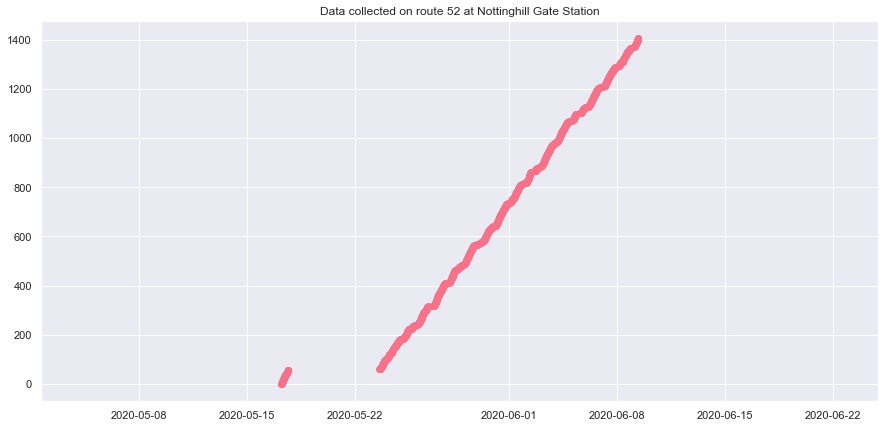

In [344]:
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b52['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
# ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
ax.set_title("Data collected on route 52 at Nottinghill Gate Station")
plt.show()

In [337]:
def predict_arrival_time(req_time, leave_stop, pred_jrny_time, most_recent_left):
    """
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred_jrny_time: predicted journey time
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """
    
    req_time = convert_time_to_datetime(req_time)

    for i, bus in leave_stop.iterrows():
        
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            leave_time = convert_time_to_datetime(bus['time_of_arrival'])
            # This vehicle is the one that left immediately after

            if leave_time <= req_time:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred_jrny_time + 30))
                return pred_arrival, bus
            # else: The nearest vehicle left stop a after the request time, so this wouldn't count as historical data
                
    # most_recent_left is the last item in the list already
    print("There are no buses due at this time from this stop")    
    return 0, []

In [338]:
def get_actual_times(arr_stop, req_time, bus_to_track, arr_stop_id):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    [bus_id, a_id, date, _, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                # REMINDER: this is only fine because the 2 stops I chose are about 5 minutes apart
                if (actual_jrny_time > dt.timedelta(minutes = 10)) or (actual_jrny_time < dt.timedelta(minutes = 3)):
                    return -1, -1
                
                print("Actual journey time is {}".format(actual_jrny_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [339]:
def pred_eval_times_mult(req_time, stop_a, stop_b, a_id, b_id, time_back, buses_back):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time and journey time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B, as well as the
    predicted and actual journey time of a bus from stop A to stop B in seconds.
    
    If the actual bus data cannot be found, return 0s all around.
    
    """
    
    print("Request time is ", req_time)
    pred_jrny_time = 0
    
    if buses_back == -1:
        # option 1) look back x hours
        pred_jrny_time, most_recent_left = predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back)
    else:
        # option 2) look back x buses TODO
        pred_jrny_time, most_recent_left = predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back)
        
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        # Can't find any journeys
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        # Can't find correlating leaving bus
        return pred_arr, 0, 0, 0
    
    actual_arr, actual_jrny_time = get_actual_times(stop_b, req_time, bus_to_track, b_id)
    
    if actual_arr == -1:
        # There is no bus arriving at req_time
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

In [340]:
def eval_historical_model(time_back, buses_back, req_times, stopa, stopb, stop_aid, stop_bid):
    preds = []
    accs = []
    req_timesx = []
    preds_jrny = []
    accs_jrny = []

    start = time.time()
    for req_time in req_times:
        pt, at, pj, aj = pred_eval_times_mult(req_time, stopa, stopb, stop_aid, stop_bid, time_back, buses_back)
        if at == 0:
            continue

        req_timesx.append(req_time)
        preds.append(pt)
        accs.append(at)
        preds_jrny.append(pj / 60)
        accs_jrny.append(aj / 60)
    
    print("Total time taken: ", (time.time() - start))
    return preds, accs, req_timesx, preds_jrny, accs_jrny

### Look back different amounts of time
1) 15 minutes

2) 30 minutes

3) 1 hour

4) 2 hours

In [245]:
def get_times_past_x_minutes(stop_a, stop_b, a_id, req_time, time_back):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past time_back 
        minutes of the request time. (not including the request time)
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time. Returns -1
        if no vehicle arrived at stop b within the past time_back hours, but before the req_time. 
        This could occur in cases where a request is made e.g. at 3 am and the bus is not a 24h bus.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past time_back 
        hours of the request time. Bus details include vehicle id.
    """

    journey_times = []
    most_recent_left = -1
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    count1 = 0
    count2 = 0

    for i, journey in stop_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        past_x_hours = req_time - dt.timedelta(minutes = time_back)

        if (arr_dt >= past_x_hours) & (arr_dt < req_time):
            count = count + 1
            # arrived within past time_back hours and before request time
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    # vehicle id matches
                    count1 = count1 + 1
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                        count2 = count2 + 1
                        most_recent_left = j
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        
    print("Number of buses that arrived at stop b within the past {} minutes: {}".format(time_back, count))
    print("Number of buses that left stop a and have an id match: ", count1)
    print("Number of buses that have feasible journey times: ", count2)
        
    return most_recent_left, arrived_journeys, journey_times

In [341]:
def predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past x hours.
    - Journey times from the past time_back minutes are weighted depending on how long ago
    they were compared to the request time.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    weights_15 = {"10": 0.65, "20": 0.35}
    weights_30 = {"10": 0.65, "20": 0.3, "40": 0.05}
    weights_60 = {"10": 0.65, "20": 0.2, "40": 0.1, "80": 0.05}
    weights_120 = {"10": 0.65, "20": 0.18, "40": 0.1, "80": 0.05, "120": 0.02}
    
    weights = weights_120
    
    most_recent_left_indx, arrived, journey_times = get_times_past_x_minutes(stop_a, stop_b, a_id, req_time, time_back)
    
    if time_back == 15:
        weights = weights_15
    elif time_back == 30:
        weights = weights_30
    elif time_back == 60:
        weights = weights_60
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["time_of_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [345]:
# Getting predicted arrival times for buses on route 52 for a gap of 5 stops.
"""
preds_52 = predicted arrival times (datetime)
accs_52 = actual arrival times (datetime)
req_timesx_52 = request times that returned valid values
preds_jrny_52 = predicted journey times (float in minutes)
accs_jrny_52 = actual journey times (timedelta in minutes)
"""

req_times_52 = generate_request_times(30, "2020-05-25 02:00:00", "2020-06-08 23:59:59")

# looking at journeys in the past 2 hours
_, _, req_timesx_52_120m, preds_jrny_52_120m, accs_jrny_52_120m = eval_historical_model(120, -1, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-25 02:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  4.766666666666667
There are no buses due at this time from this stop
Request time is  2020-05-25 02:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  4.766666666666667
There are no buses due at this time from this stop
Request time is  2020-05-25 03:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-25 03:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses 

Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-25 16:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-25 17:00:00
Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  14
Number of buses that have feasible journey times:  2
Predicted journey time is  6.157028112449798
Request time is  2020-05-25 17:30:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  19
Number of buses that have feasible journey times:  2
Predicted journey time is  6.205555555555555
Request tim

Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times:  11
Predicted journey time is  4.8999999999999995
There are no buses due at this time from this stop
Request time is  2020-05-26 07:00:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  11
Predicted journey time is  5.424289405684755
There are no buses due at this time from this stop
Request time is  2020-05-26 07:30:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times:  11
Predicted journey time is  5.654292929292931
Request time is  2020-05-26 08:00:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left st

There are no buses due at this time from this stop
Request time is  2020-05-26 21:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-26 21:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-26 22:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-26 22:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible jo

Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  10
Predicted journey time is  6.224043715846995
Request time is  2020-05-27 12:30:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  47
Number of buses that have feasible journey times:  7
Predicted journey time is  6.546794871794872
Request time is  2020-05-27 13:00:00
Number of buses that arrived at stop b within the past 120 minutes: 7
Number of buses that left stop a and have an id match:  43
Number of buses that have feasible journey times:  4
Predicted journey time is  5.754545454545454
Request time is  2020-05-27 13:30:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  47
Number of buses that have feasible journey times:  5
Predicted journey time i

Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  7.7
There are no buses due at this time from this stop
Request time is  2020-05-28 03:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  7.7
Actual journey time is 0:04:49
Request time is  2020-05-28 03:30:00
Number of buses that arrived at stop b within the past 120 minutes: 2
Number of buses that left stop a and have an id match:  3
Number of buses that have feasible journey times:  2
Predicted journey time is  4.8805555555555555
Actual journey time is 0:05:59
Request time is  2020-05-28 04:00:00
Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match: 

Number of buses that arrived at stop b within the past 120 minutes: 6
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  5
Predicted journey time is  6.821052631578947
Actual journey time is 0:07:11
Request time is  2020-05-28 17:30:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  7
Predicted journey time is  4.9237373737373735
There are no buses due at this time from this stop
Request time is  2020-05-28 18:00:00
Number of buses that arrived at stop b within the past 120 minutes: 7
Number of buses that left stop a and have an id match:  40
Number of buses that have feasible journey times:  7
Predicted journey time is  5.83425925925926
There are no buses due at this time from this stop
Request time is  2020-05-28 18:30:00
Number of buses that arrived at stop b within the past 120 minutes: 5
Numbe

Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  66
Number of buses that have feasible journey times:  11
Predicted journey time is  6.34537037037037
There are no buses due at this time from this stop
Request time is  2020-05-29 07:00:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  11
Predicted journey time is  5.5996124031007755
Actual journey time is 0:08:20
Request time is  2020-05-29 07:30:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times:  11
Predicted journey time is  5.133080808080808
Request time is  2020-05-29 08:00:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id m

Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-29 21:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-29 22:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-29 22:30:00
Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  1
Predicted journey time is  3.2500000000000004
There are no buses due at

Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  57
Number of buses that have feasible journey times:  10
Predicted journey time is  5.070997375328084
There are no buses due at this time from this stop
Request time is  2020-05-30 11:30:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  11
Predicted journey time is  6.903581267217632
Actual journey time is 0:07:14
Request time is  2020-05-30 12:00:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  60
Number of buses that have feasible journey times:  11
Predicted journey time is  6.441005291005293
There are no buses due at this time from this stop
Request time is  2020-05-30 12:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1

Request time is  2020-05-31 01:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  4.6
Request time is  2020-05-31 01:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-31 02:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-31 02:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Requ

Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  71
Number of buses that have feasible journey times:  10
Predicted journey time is  7.40013440860215
There are no buses due at this time from this stop
Request time is  2020-05-31 15:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  67
Number of buses that have feasible journey times:  10
Predicted journey time is  6.724739583333335
Actual journey time is 0:06:58
Request time is  2020-05-31 16:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  10
Predicted journey time is  4.3656862745098035
There are no buses due at this time from this stop
Request time is  2020-05-31 16:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1

Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  9
Predicted journey time is  4.466666666666668
Actual journey time is 0:04:57
Request time is  2020-06-01 06:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  64
Number of buses that have feasible journey times:  10
Predicted journey time is  4.5458333333333325
Actual journey time is 0:07:49
Request time is  2020-06-01 06:30:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  9
Predicted journey time is  5.032558139534885
Request time is  2020-06-01 07:00:00
Number of buses that arrived at stop b within the past 120 minutes: 7
Number of buses that left stop a and have an id match:  44
Number of buse

Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  29
Number of buses that have feasible journey times:  3
Predicted journey time is  5.671428571428572
Request time is  2020-06-01 20:00:00
Number of buses that arrived at stop b within the past 120 minutes: 2
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  1
Predicted journey time is  5.416666666666667
Request time is  2020-06-01 20:30:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  30
Number of buses that have feasible journey times:  1
Predicted journey time is  5.416666666666667
Request time is  2020-06-01 21:00:00
Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  23
Number of buses that have feasible journey times:  1
Predicted journey time is 

Request time is  2020-06-02 10:00:00
Number of buses that arrived at stop b within the past 120 minutes: 13
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  13
Predicted journey time is  5.875177304964539
Actual journey time is 0:07:50
Request time is  2020-06-02 10:30:00
Number of buses that arrived at stop b within the past 120 minutes: 13
Number of buses that left stop a and have an id match:  54
Number of buses that have feasible journey times:  13
Predicted journey time is  6.7601715686274515
There are no buses due at this time from this stop
Request time is  2020-06-02 11:00:00
Number of buses that arrived at stop b within the past 120 minutes: 12
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  12
Predicted journey time is  6.475245098039215
There are no buses due at this time from this stop
Request time is  2020-06-02 11:30:00
Number of buses that arrived at

Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  2
Predicted journey time is  4.811111111111111
There are no buses due at this time from this stop
Request time is  2020-06-03 01:00:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  2
Predicted journey time is  5.063095238095238
There are no buses due at this time from this stop
Request time is  2020-06-03 01:30:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  2
Predicted journey time is  5.013888888888888
There are no buses due at this time from this stop
Request time is  2020-06-03 02:00:00
Number of buses that arrived at stop b within the past 12

Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  9
Predicted journey time is  7.381432748538011
There are no buses due at this time from this stop
Request time is  2020-06-03 15:00:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  64
Number of buses that have feasible journey times:  9
Predicted journey time is  7.5567796610169475
Actual journey time is 0:08:53
Request time is  2020-06-03 15:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  71
Number of buses that have feasible journey times:  10
Predicted journey time is  7.443393393393395
There are no buses due at this time from this stop
Request time is  2020-06-03 16:00:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Nu

Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  5
Predicted journey time is  3.817833333333333
There are no buses due at this time from this stop
Request time is  2020-06-04 04:30:00
Number of buses that arrived at stop b within the past 120 minutes: 6
Number of buses that left stop a and have an id match:  32
Number of buses that have feasible journey times:  6
Predicted journey time is  4.585910652920961
There are no buses due at this time from this stop
Request time is  2020-06-04 05:00:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  8
Predicted journey time is  4.21125
There are no buses due at this time from this stop
Request time is  2020-06-04 05:30:00
Number of buses that arrived at stop b within the past 120 minute

Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  9
Predicted journey time is  6.650450450450451
There are no buses due at this time from this stop
Request time is  2020-06-04 18:30:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  54
Number of buses that have feasible journey times:  7
Predicted journey time is  6.653763440860214
There are no buses due at this time from this stop
Request time is  2020-06-04 19:00:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  49
Number of buses that have feasible journey times:  6
Predicted journey time is  6.8715053763440865
Request time is  2020-06-04 19:30:00
Number of buses that arrived at stop b within the past 120 minutes: 7
Number of buses that left stop a an

Actual journey time is 0:06:37
Request time is  2020-06-05 08:00:00
Number of buses that arrived at stop b within the past 120 minutes: 12
Number of buses that left stop a and have an id match:  50
Number of buses that have feasible journey times:  12
Predicted journey time is  5.85445292620865
Actual journey time is 0:07:56
Request time is  2020-06-05 08:30:00
Number of buses that arrived at stop b within the past 120 minutes: 13
Number of buses that left stop a and have an id match:  56
Number of buses that have feasible journey times:  13
Predicted journey time is  5.849763593380615
There are no buses due at this time from this stop
Request time is  2020-06-05 09:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  10
Predicted journey time is  6.05891472868217
There are no buses due at this time from this stop
Request time is  2020-06-05 09:30:00
Num

Request time is  2020-06-05 23:00:00
Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match:  19
Number of buses that have feasible journey times:  5
Predicted journey time is  4.856944444444443
Request time is  2020-06-05 23:30:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  4
Predicted journey time is  4.417222222222223
There are no buses due at this time from this stop
Request time is  2020-06-06 00:00:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  4
Predicted journey time is  4.439393939393939
There are no buses due at this time from this stop
Request time is  2020-06-06 00:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1

Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  51
Number of buses that have feasible journey times:  8
Predicted journey time is  7.38739837398374
There are no buses due at this time from this stop
Request time is  2020-06-06 13:30:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  59
Number of buses that have feasible journey times:  8
Predicted journey time is  6.886217948717948
Actual journey time is 0:06:17
Request time is  2020-06-06 14:00:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  54
Number of buses that have feasible journey times:  7
Predicted journey time is  8.739756944444444
Actual journey time is 0:07:40
Request time is  2020-06-06 14:30:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left 

There are no buses due at this time from this stop
Request time is  2020-06-07 03:00:00
Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  3
Predicted journey time is  4.546078431372549
There are no buses due at this time from this stop
Request time is  2020-06-07 03:30:00
Number of buses that arrived at stop b within the past 120 minutes: 2
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  2
Predicted journey time is  4.559523809523808
There are no buses due at this time from this stop
Request time is  2020-06-07 04:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  1
Predicted journey time is  4.55
Request time is  2020-06-07 04:30:00
Number of buses that arrived at

Actual journey time is 0:08:54
Request time is  2020-06-07 17:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  61
Number of buses that have feasible journey times:  10
Predicted journey time is  5.588152610441767
Request time is  2020-06-07 17:30:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  52
Number of buses that have feasible journey times:  8
Predicted journey time is  5.963008130081302
Request time is  2020-06-07 18:00:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  5
Predicted journey time is  5.948958333333334
Request time is  2020-06-07 18:30:00
Number of buses that arrived at stop b within the past 120 minutes: 7
Number of buses that left stop a and have an id match:  41
Number of

Request time is  2020-06-08 08:00:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  28
Number of buses that have feasible journey times:  4
Predicted journey time is  4.8375
Request time is  2020-06-08 08:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  4.6
Request time is  2020-06-08 09:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  5.883333333333334
Actual journey time is 0:06:26
Request time is  2020-06-08 09:30:00
Number of buses that arrived at stop b within the past 120 minutes: 4
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible jou

Number of buses that arrived at stop b within the past 120 minutes: 6
Number of buses that left stop a and have an id match:  33
Number of buses that have feasible journey times:  4
Predicted journey time is  5.419753086419754
Request time is  2020-06-08 22:30:00
Number of buses that arrived at stop b within the past 120 minutes: 6
Number of buses that left stop a and have an id match:  39
Number of buses that have feasible journey times:  4
Predicted journey time is  6.150216450216449
There are no buses due at this time from this stop
Request time is  2020-06-08 23:00:00
Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match:  30
Number of buses that have feasible journey times:  4
Predicted journey time is  5.730555555555556
Request time is  2020-06-08 23:30:00
Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  23
Number of buses that have fe

In [349]:
len(preds_jrny_52_120m)

172

In [371]:
reduced_preds = tfl_predictions.loc[(tfl_predictions['start_stop'] == "Chesterton Road") & (tfl_predictions['end_stop'] == "Notting Hill Gate Station")]
tfl_preds_52 = []
for x in reduced_preds['pred_jrny_time']:
    minutes = int(x[2:4])
    seconds = int(x[5:])
    tfl_preds_52.append(minutes + (seconds / 60))

tfl_times = [convert_time_to_datetime(x) for x in reduced_preds['time_of_req']]
tfl_times

[datetime.datetime(2020, 6, 1, 14, 45),
 datetime.datetime(2020, 6, 1, 15, 0),
 datetime.datetime(2020, 6, 1, 15, 15),
 datetime.datetime(2020, 6, 1, 15, 30),
 datetime.datetime(2020, 6, 1, 15, 45),
 datetime.datetime(2020, 6, 1, 16, 0),
 datetime.datetime(2020, 6, 1, 16, 15),
 datetime.datetime(2020, 6, 1, 16, 30),
 datetime.datetime(2020, 6, 1, 16, 45),
 datetime.datetime(2020, 6, 1, 17, 0),
 datetime.datetime(2020, 6, 1, 17, 15),
 datetime.datetime(2020, 6, 1, 17, 30),
 datetime.datetime(2020, 6, 1, 17, 45),
 datetime.datetime(2020, 6, 1, 18, 15),
 datetime.datetime(2020, 6, 1, 18, 15),
 datetime.datetime(2020, 6, 1, 18, 45),
 datetime.datetime(2020, 6, 1, 18, 45),
 datetime.datetime(2020, 6, 1, 19, 15),
 datetime.datetime(2020, 6, 1, 19, 30),
 datetime.datetime(2020, 6, 1, 19, 30),
 datetime.datetime(2020, 6, 1, 20, 0),
 datetime.datetime(2020, 6, 1, 20, 15),
 datetime.datetime(2020, 6, 1, 21, 30),
 datetime.datetime(2020, 6, 1, 21, 30),
 datetime.datetime(2020, 6, 1, 21, 45),
 dat

In [380]:
print(len(tfl_preds_52))
print(len(accs_jrny_52_120m))

584
172


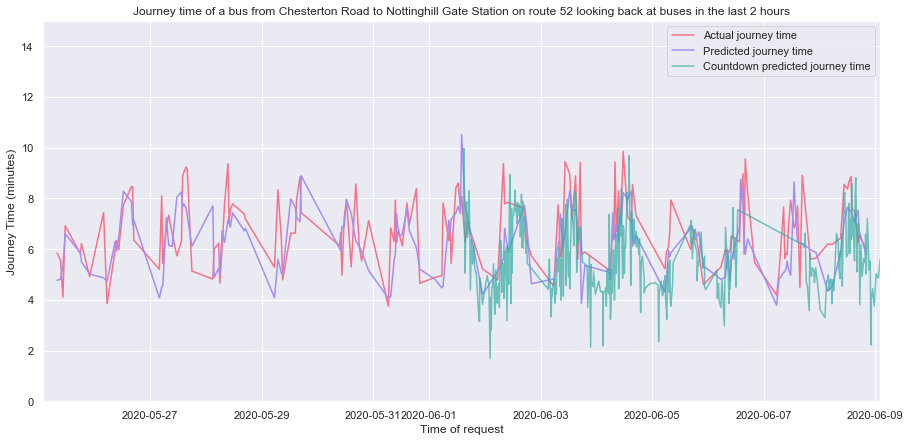

In [389]:
times_52_120m = [convert_time_to_datetime(t) for t in req_timesx_52_120m]
actual_jrny_52_120m = [x.total_seconds() for x in accs_jrny_52_120m]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_52_120m, actual_jrny_52_120m, label="Actual journey time")
ax.plot(times_52_120m, preds_jrny_52_120m, label="Predicted journey time", color=cs[6])
ax.plot(tfl_times, tfl_preds_52, label="Countdown predicted journey time", color=cs[4], alpha=0.7)
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_ylim(0, 15)
ax.set_xlim([dt.datetime(2020, 5, 25, 2), dt.datetime(2020, 6, 9, 2)])
ax.set_title("Journey time of a bus from Chesterton Road to Nottinghill Gate Station on route 52 looking back at buses in the last 2 hours")
ax.legend()

plt.show()

In [352]:
req_times_52_reduced = generate_request_times(30, "2020-05-29 02:00:00", "2020-06-08 23:59:59")

# looking at journeys in the past 15 minutes
_, _, req_timesx_52_15m, preds_jrny_52_15m, accs_jrny_52_15m = eval_historical_model(15, -1, req_times_52_reduced, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 30 minutes
_, _, req_timesx_52_30m, preds_jrny_52_30m, accs_jrny_52_30m = eval_historical_model(30, -1, req_times_52_reduced, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 60 minutes
_, _, req_timesx_52_60m, preds_jrny_52_60m, accs_jrny_52_60m = eval_historical_model(60, -1, req_times_52_reduced, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-29 02:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  4.4
There are no buses due at this time from this stop
Request time is  2020-05-29 02:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  4.016666666666667
There are no buses due at this time from this stop
Request time is  2020-05-29 03:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  5.416666666666667
There are no buses due at this time from this stop
Request time is  2020-05-29 03:30:00
Number of buses that arrived at stop b

There are no buses due at this time from this stop
Request time is  2020-05-29 16:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  7.533333333333333
Request time is  2020-05-29 16:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-29 17:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  9.533333333333333
Actual journey time is 0:07:26
Request time is  2020-05-29 17:30:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and hav

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-30 08:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  5.183333333333334
Request time is  2020-05-30 09:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-30 09:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  6.133333333333334
Actual journey ti

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-30 23:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  2.7333333333333334
There are no buses due at this time from this stop
Request time is  2020-05-30 23:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-31 00:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted 

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  6.216666666666667
There are no buses due at this time from this stop
Request time is  2020-05-31 13:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  6.9
There are no buses due at this time from this stop
Request time is  2020-05-31 14:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  2
Predicted journey time is  6.388333333333334
There are no buses due at this time from this stop
Request time is  2020-05-31 14:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Numbe

There are no buses due at this time from this stop
Request time is  2020-06-01 03:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  3.6333333333333337
There are no buses due at this time from this stop
Request time is  2020-06-01 04:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  2
Predicted journey time is  5.075
Request time is  2020-06-01 04:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  5.133333333333334
There are no buses due at this time from this stop
Request time is  2020-06-01 05:00:00
Number of buses that arrived at st

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  5.266666666666667
There are no buses due at this time from this stop
Request time is  2020-06-01 18:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  6.8500000000000005
Request time is  2020-06-01 18:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-01 19:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  1
Predicted journey time is  7.866666666666666
Actual journey time is 0:07:47
Request time is  2020-06-02 09:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  2
Predicted journey time is  5.694166666666666
There are no buses due at this time from this stop
Request time is  2020-06-02 09:30:00
Number of buses that arrived at stop b within the past 15 minutes: 3
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  3
Predicted journey time is  5.62929292929293
Request time is  2020-06-02 10:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  14
Numb

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-03 01:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  5.1
There are no buses due at this time from this stop
Request time is  2020-06-03 01:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-03 02:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  7.35
Actual journey time is 0:08:53
Request time is  2020-06-03 15:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  4
Number of buses that have feasible journey times:  1
Predicted journey time is  7.533333333333333
There are no buses due at this time from this stop
Request time is  2020-06-03 16:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  6.333333333333333
Actual journey time is 0:05:36
Request time is  2020-06-03 16:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an 

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  5.4
Actual journey time is 0:05:10
Request time is  2020-06-04 06:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  2
Predicted journey time is  4.821666666666667
Actual journey time is 0:05:17
Request time is  2020-06-04 06:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  5.75
There are no buses due at this time from this stop
Request time is  2020-06-04 07:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  6
N

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-04 20:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-04 21:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  5.3
Request time is  2020-06-04 21:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-04 22:00:00
Number o

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 12:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 12:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 13:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 13:30:00
Number o

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  4.983333333333333
There are no buses due at this time from this stop
Request time is  2020-06-06 04:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  2
Predicted journey time is  4.808333333333334
There are no buses due at this time from this stop
Request time is  2020-06-06 04:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  4.6
There are no buses due at this time from this stop
Request time is  2020-06-06 05:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Numbe

Actual journey time is 0:08:14
Request time is  2020-06-06 17:30:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-06 18:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-06 18:30:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  2
Predicted journey time is  6.2325
There are no buses due at this time from this stop
Request time is  2020-06-06 19:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Numbe

Actual journey time is 0:07:39
Request time is  2020-06-07 09:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  4.266666666666667
Actual journey time is 0:05:38
Request time is  2020-06-07 09:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  5.333333333333333
Actual journey time is 0:05:50
Request time is  2020-06-07 10:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  1
Predicted journey time is  5.816666666666666
Actual journey time is 0:05:47
Request time is  2020-06-07 10:30:00
Number of buses that arrived at stop b within the pa

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 00:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 01:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 01:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 02:00:00
Number o

There are no buses due at this time from this stop
Request time is  2020-06-08 15:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  1
Predicted journey time is  5.483333333333333
Actual journey time is 0:07:31
Request time is  2020-06-08 15:30:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  2
Predicted journey time is  8.01
There are no buses due at this time from this stop
Request time is  2020-06-08 16:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  2
Predicted journey time is  5.270833333333333
There are no buses due at this time from this stop
Request time is  2020-06-08 16:30:00
Numbe

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  3
Predicted journey time is  5.503333333333333
Actual journey time is 0:08:20
Request time is  2020-05-29 07:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  2
Predicted journey time is  3.6190476190476195
Request time is  2020-05-29 08:00:00
Number of buses that arrived at stop b within the past 30 minutes: 4
Number of buses that left stop a and have an id match:  21
Number of buses that have feasible journey times:  4
Predicted journey time is  5.254761904761905
There are no buses due at this time from this stop
Request time is  2020-05-29 08:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  20


Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-29 22:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  1
Predicted journey time is  3.25
There are no buses due at this time from this stop
Request time is  2020-05-29 23:00:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-29 23:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  1
Predicted journey time

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  3
Predicted journey time is  7.417500000000001
There are no buses due at this time from this stop
Request time is  2020-05-30 13:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  2
Predicted journey time is  5.228947368421052
There are no buses due at this time from this stop
Request time is  2020-05-30 14:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  3
Predicted journey time is  6.770833333333333
There are no buses due at this time from this stop
Request time is  2020-05-30 14:30:00
Number of buses that arrived at stop b within the past 30 

There are no buses due at this time from this stop
Request time is  2020-05-31 04:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  2
Predicted journey time is  3.933333333333333
There are no buses due at this time from this stop
Request time is  2020-05-31 04:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  14
Number of buses that have feasible journey times:  2
Predicted journey time is  3.622619047619047
There are no buses due at this time from this stop
Request time is  2020-05-31 05:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  3
Predicted journey time is  4.545
There are no buses due at this time from this stop
Request time is  20

Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  2
Predicted journey time is  7.108771929824561
There are no buses due at this time from this stop
Request time is  2020-05-31 18:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  21
Number of buses that have feasible journey times:  3
Predicted journey time is  6.855833333333333
Request time is  2020-05-31 18:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  2
Predicted journey time is  5.590350877192983
Actual journey time is 0:08:23
Request time is  2020-05-31 19:00:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  7
Nu

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  1
Predicted journey time is  7.1833333333333345
Actual journey time is 0:06:20
Request time is  2020-06-01 09:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  22
Number of buses that have feasible journey times:  3
Predicted journey time is  6.677499999999999
Actual journey time is 0:06:56
Request time is  2020-06-01 09:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  3
Predicted journey time is  7.291975308641976
Actual journey time is 0:05:26
Request time is  2020-06-01 10:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id 

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  1
Predicted journey time is  4.3
Actual journey time is 0:05:13
Request time is  2020-06-01 23:30:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  4.716666666666667
There are no buses due at this time from this stop
Request time is  2020-06-02 00:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 00:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasib

Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 14:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 14:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 15:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 15:30:00
Number o

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  21
Number of buses that have feasible journey times:  3
Predicted journey time is  5.586666666666667
There are no buses due at this time from this stop
Request time is  2020-06-03 05:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  2
Predicted journey time is  4.938095238095238
Actual journey time is 0:04:33
Request time is  2020-06-03 06:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  3
Predicted journey time is  4.941666666666666
Actual journey time is 0:05:08
Request time is  2020-06-03 06:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left sto

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  5.283333333333333
Actual journey time is 0:05:53
Request time is  2020-06-03 19:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  2
Predicted journey time is  5.397619047619048
There are no buses due at this time from this stop
Request time is  2020-06-03 20:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-03 20:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  18
Number of buses t

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  19
Number of buses that have feasible journey times:  3
Predicted journey time is  7.203333333333334
Actual journey time is 0:07:22
Request time is  2020-06-04 09:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  3
Predicted journey time is  5.9591666666666665
Actual journey time is 0:08:17
Request time is  2020-06-04 10:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  20
Number of buses that have feasible journey times:  3
Predicted journey time is  7.333333333333333
Actual journey time is 0:07:26
Request time is  2020-06-04 10:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id 

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  4.533333333333333
There are no buses due at this time from this stop
Request time is  2020-06-05 00:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 00:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 01:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted j

Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 15:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 15:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 16:00:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 16:30:00
Number o

Actual journey time is 0:05:17
Request time is  2020-06-06 06:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  22
Number of buses that have feasible journey times:  3
Predicted journey time is  4.1225
There are no buses due at this time from this stop
Request time is  2020-06-06 06:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  2
Predicted journey time is  4.486842105263158
Request time is  2020-06-06 07:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  2
Predicted journey time is  3.7773809523809523
There are no buses due at this time from this stop
Request time is  2020-06-06 07:30:00
Number of buses that arrived at stop b within the p

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  5.983333333333333
Actual journey time is 0:05:28
Request time is  2020-06-06 20:30:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  4.966666666666667
Request time is  2020-06-06 21:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-06 21:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  12
Number of buses that have feasible journey times:  1
Predicted journe

Actual journey time is 0:06:46
Request time is  2020-06-07 11:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  3
Predicted journey time is  6.216666666666667
There are no buses due at this time from this stop
Request time is  2020-06-07 11:30:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  3.1666666666666665
Actual journey time is 0:07:56
Request time is  2020-06-07 12:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  19
Number of buses that have feasible journey times:  3
Predicted journey time is  4.865833333333334
There are no buses due at this time from this stop
Request time is  2020-06-07 12:30:00
Number of 

Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 02:30:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  3.25
There are no buses due at this time from this stop
Request time is  2020-06-08 03:00:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  4.883333333333334
There are no buses due at this time from this stop
Request time is  2020-06-08 03:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of bu

There are no buses due at this time from this stop
Request time is  2020-06-08 16:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  2
Predicted journey time is  7.9596491228070185
Actual journey time is 0:06:15
Request time is  2020-06-08 17:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  2
Predicted journey time is  6.364285714285714
Actual journey time is 0:06:32
Request time is  2020-06-08 17:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  20
Number of buses that have feasible journey times:  3
Predicted journey time is  6.531666666666666
Request time is  2020-06-08 18:00:00
Number of buses that arrived at stop b within the past 30 mi

There are no buses due at this time from this stop
Request time is  2020-05-29 08:30:00
Number of buses that arrived at stop b within the past 60 minutes: 7
Number of buses that left stop a and have an id match:  41
Number of buses that have feasible journey times:  7
Predicted journey time is  5.084027777777777
Actual journey time is 0:06:21
Request time is  2020-05-29 09:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  38
Number of buses that have feasible journey times:  6
Predicted journey time is  5.06304347826087
Actual journey time is 0:04:47
Request time is  2020-05-29 09:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  38
Number of buses that have feasible journey times:  6
Predicted journey time is  6.457291666666667
Request time is  2020-05-29 10:00:00
Number of buses that arrived at stop b within the past 60 minu

Number of buses that arrived at stop b within the past 60 minutes: 3
Number of buses that left stop a and have an id match:  23
Number of buses that have feasible journey times:  1
Predicted journey time is  4.25
There are no buses due at this time from this stop
Request time is  2020-05-30 00:00:00
Number of buses that arrived at stop b within the past 60 minutes: 2
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  1
Predicted journey time is  4.25
There are no buses due at this time from this stop
Request time is  2020-05-30 00:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-30 01:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that ha

Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  29
Number of buses that have feasible journey times:  5
Predicted journey time is  6.468181818181818
There are no buses due at this time from this stop
Request time is  2020-05-30 14:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  5
Predicted journey time is  7.5626984126984125
Actual journey time is 0:05:18
Request time is  2020-05-30 15:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  27
Number of buses that have feasible journey times:  5
Predicted journey time is  7.030303030303029
There are no buses due at this time from this stop
Request time is  2020-05-30 15:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number o

Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  4
Predicted journey time is  3.7491228070175437
There are no buses due at this time from this stop
Request time is  2020-05-31 05:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  32
Number of buses that have feasible journey times:  5
Predicted journey time is  4.546969696969697
There are no buses due at this time from this stop
Request time is  2020-05-31 05:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  32
Number of buses that have feasible journey times:  5
Predicted journey time is  4.1912280701754385
There are no buses due at this time from this stop
Request time is  2020-05-31 06:00:00
Number of buses that arrived at stop b within the past 6

Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  33
Number of buses that have feasible journey times:  5
Predicted journey time is  6.807575757575758
Request time is  2020-05-31 18:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  36
Number of buses that have feasible journey times:  5
Predicted journey time is  5.888095238095238
Actual journey time is 0:08:23
Request time is  2020-05-31 19:00:00
Number of buses that arrived at stop b within the past 60 minutes: 3
Number of buses that left stop a and have an id match:  22
Number of buses that have feasible journey times:  3
Predicted journey time is  6.496666666666667
Request time is  2020-05-31 19:30:00
Number of buses that arrived at stop b within the past 60 minutes: 3
Number of buses that left stop a and have an id match:  19
Number of buses that have feasible journey times:  2

Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  4
Predicted journey time is  6.6801587301587295
Actual journey time is 0:06:56
Request time is  2020-06-01 09:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  37
Number of buses that have feasible journey times:  6
Predicted journey time is  7.166145833333333
Actual journey time is 0:05:26
Request time is  2020-06-01 10:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  36
Number of buses that have feasible journey times:  6
Predicted journey time is  6.765972222222222
There are no buses due at this time from this stop
Request time is  2020-06-01 10:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left st

Actual journey time is 0:05:13
Request time is  2020-06-01 23:30:00
Number of buses that arrived at stop b within the past 60 minutes: 2
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  2
Predicted journey time is  4.508333333333334
There are no buses due at this time from this stop
Request time is  2020-06-02 00:00:00
Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  4.716666666666667
Request time is  2020-06-02 00:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 01:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and ha

Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 14:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 15:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 15:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-02 16:00:00
Number o

Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  36
Number of buses that have feasible journey times:  5
Predicted journey time is  5.337878787878788
There are no buses due at this time from this stop
Request time is  2020-06-03 05:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  38
Number of buses that have feasible journey times:  5
Predicted journey time is  4.9605263157894735
Actual journey time is 0:04:33
Request time is  2020-06-03 06:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  33
Number of buses that have feasible journey times:  5
Predicted journey time is  4.805303030303029
Actual journey time is 0:05:08
Request time is  2020-06-03 06:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left st

Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  5.283333333333333
Actual journey time is 0:05:53
Request time is  2020-06-03 19:30:00
Number of buses that arrived at stop b within the past 60 minutes: 3
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  3
Predicted journey time is  5.366666666666666
There are no buses due at this time from this stop
Request time is  2020-06-03 20:00:00
Number of buses that arrived at stop b within the past 60 minutes: 2
Number of buses that left stop a and have an id match:  17
Number of buses that have feasible journey times:  2
Predicted journey time is  5.391666666666667
Request time is  2020-06-03 20:30:00
Number of buses that arrived at stop b within the past 60 minutes: 3
Number of buses that left stop a and have an id match:  18
Nu

Number of buses that arrived at stop b within the past 60 minutes: 7
Number of buses that left stop a and have an id match:  51
Number of buses that have feasible journey times:  7
Predicted journey time is  6.995833333333333
Actual journey time is 0:07:22
Request time is  2020-06-04 09:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  6
Predicted journey time is  6.134782608695653
Actual journey time is 0:08:17
Request time is  2020-06-04 10:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  35
Number of buses that have feasible journey times:  6
Predicted journey time is  7.297101449275362
Actual journey time is 0:07:26
Request time is  2020-06-04 10:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id m

Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  4.533333333333333
There are no buses due at this time from this stop
Request time is  2020-06-05 00:00:00
Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  4.533333333333333
There are no buses due at this time from this stop
Request time is  2020-06-05 00:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 01:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0

Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 15:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 15:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 16:00:00
Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-05 16:30:00
Number o

Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  28
Number of buses that have feasible journey times:  4
Predicted journey time is  4.839166666666667
Actual journey time is 0:05:17
Request time is  2020-06-06 06:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  5
Predicted journey time is  4.3522727272727275
There are no buses due at this time from this stop
Request time is  2020-06-06 06:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  5
Predicted journey time is  4.414285714285715
Request time is  2020-06-06 07:00:00
Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  28


Request time is  2020-06-06 19:30:00
Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  27
Number of buses that have feasible journey times:  4
Predicted journey time is  4.7891666666666675
There are no buses due at this time from this stop
Request time is  2020-06-06 20:00:00
Number of buses that arrived at stop b within the past 60 minutes: 3
Number of buses that left stop a and have an id match:  22
Number of buses that have feasible journey times:  3
Predicted journey time is  5.745833333333334
Actual journey time is 0:05:28
Request time is  2020-06-06 20:30:00
Number of buses that arrived at stop b within the past 60 minutes: 2
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  2
Predicted journey time is  5.475
Request time is  2020-06-06 21:00:00
Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a a

Actual journey time is 0:05:50
Request time is  2020-06-07 10:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  39
Number of buses that have feasible journey times:  6
Predicted journey time is  5.5628787878787875
Actual journey time is 0:05:47
Request time is  2020-06-07 10:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  39
Number of buses that have feasible journey times:  6
Predicted journey time is  5.234057971014493
Actual journey time is 0:06:46
Request time is  2020-06-07 11:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  36
Number of buses that have feasible journey times:  6
Predicted journey time is  6.0978260869565215
There are no buses due at this time from this stop
Request time is  2020-06-07 11:30:00
Number of buses that arrived

Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 01:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 01:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 02:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-06-08 02:30:00
Number o

Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  5
Predicted journey time is  6.918333333333334
Actual journey time is 0:07:31
Request time is  2020-06-08 15:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  29
Number of buses that have feasible journey times:  5
Predicted journey time is  7.678571428571429
There are no buses due at this time from this stop
Request time is  2020-06-08 16:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  33
Number of buses that have feasible journey times:  6
Predicted journey time is  5.380434782608696
There are no buses due at this time from this stop
Request time is  2020-06-08 16:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of

### Measuring Success

**Mean Absolute Percentage Error:** (MAPE). lower values are better. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

**Root Mean Square Error** (rmse). Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. The smaller the better

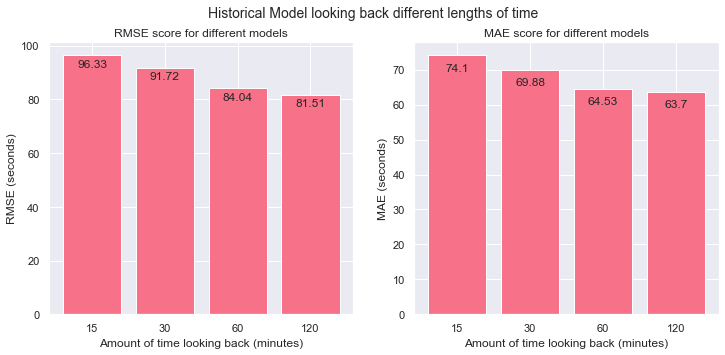

In [381]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_jrny_preds_52 = [preds_jrny_52_15m, preds_jrny_52_30m, preds_jrny_52_60m, preds_jrny_52_120m]
all_jrny_accs_52 = [accs_jrny_52_15m, accs_jrny_52_30m, accs_jrny_52_60m, accs_jrny_52_120m]

mapes_52m = []
rmses_52m = []

for i, time_back in enumerate(all_jrny_preds_52): 
    
    actual_seconds = [(a.total_seconds() * 60) for a in all_jrny_accs_52[i]]
    predicted_seconds = [p * 60 for p in time_back]

    mape52 = mean_absolute_error(actual_seconds, predicted_seconds)
    mse52 = mean_squared_error(actual_seconds, predicted_seconds)
    rmse52 = np.sqrt(mse52)

    mapes_52m.append(mape52)
    rmses_52m.append(rmse52)
    
time_back_labels = ["15", "30", "60", "120"]

fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].bar(time_back_labels, rmses_52m)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Amount of time looking back (minutes)")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmsem = [round(rmses_52m[0], 2), round(rmses_52m[1], 2), round(rmses_52m[2], 2), round(rmses_52m[3], 2)]

for rect, label in zip(rects_rmse, labels_rmsem):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(time_back_labels, mapes_52m)
ax[1].set_title("MAE score for different models")
ax[1].set_xlabel("Amount of time looking back (minutes)")
ax[1].set_ylabel("MAE (seconds)")

rects_mape = ax[1].patches
labels_mapem = [round(mapes_52m[0], 2), round(mapes_52m[1], 2), round(mapes_52m[2], 2), round(mapes_52m[3], 2)]

for rect, label in zip(rects_mape, labels_mapem):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back different lengths of time', fontsize=14)
plt.show()

### Look back different numbers of buses
1) 2 buses

2) 5 buses

3) 10 buses

4) 15 buses

In [383]:
def get_times_past_x_buses(stop_a, stop_b, a_id, req_time, buses_back):
    
    """
    journey_times 
        - is a list of journey times for the last buses_back number of buses arriving at 
        stop b 
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b. 1st in the list is the
        most recent bus to have arrived, last in the list is the oldest bus to arrive.
    """

    journey_times = []
    left_indices = []
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    
    # reverse direction of stop b entries.
    reversed_b = stop_b.sort_values(by='time_of_arrival', ascending=False, ignore_index=True)

    for i, journey in reversed_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        
        if arr_dt < req_time:
            # first one we encounter is the most recent arrived.
            
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    
                    # vehicle id matches
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 2)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                            
                        left_indices.append(j)
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        count = count + 1
                        break
            
        if count == buses_back:
            break
    
    most_recent_left = -1
    if len(left_indices) > 0:
        most_recent_left = left_indices[0]
    
    return most_recent_left, arrived_journeys, journey_times

In [384]:
def predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times for the past x buses back
    - Journey times from the past time_back minutes are weighted depending on how many buses
    back we are looking.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    weights_2 = {"2": 1}
    weights_5 = {"2": 0.55, "5": 0.45}
    weights_10 = {"2": 0.55, "5": 0.35, "10": 0.1}
    weights_15 = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}
    
    weights = weights_10
    
    most_recent_left_indx, arrived, journey_times = get_times_past_x_buses(stop_a, stop_b, a_id, req_time, buses_back)
    
    if buses_back == 2:
        weights = weights_2
    elif buses_back == 5:
        weights = weights_5
    elif buses_back == 15:
        weights = weights_15
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        weight = 0
        if (index < 2):
            weight = weights["2"]
        elif (index < 5) & (index >= 2):
            weight = weights["5"]
        elif (index < 10) & (index >= 5):
            weight = weights["10"]
        elif (index < 15) & (index >= 10):
            weight = weights["15"]

        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [385]:
# Getting predicted arrival times for buses on route 52 for a gap of 5 stops.
"""
preds_52 = predicted arrival times (datetime)
accs_52 = actual arrival times (datetime)
req_timesx_52 = request times that returned valid values
preds_jrny_52 = predicted journey times (float in minutes)
accs_jrny_52 = actual journey times (timedelta in minutes)
"""

req_times_52 = generate_request_times(30, "2020-05-25 02:00:00", "2020-06-08 23:59:59")

# looking at journeys for the past 2 buses
_, _, req_timesx_52_2b, preds_jrny_52_2b, accs_jrny_52_2b = eval_historical_model(0, 2, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-25 02:00:00
Predicted journey time is  5.041666666666667
There are no buses due at this time from this stop
Request time is  2020-05-25 02:30:00
Predicted journey time is  5.041666666666667
There are no buses due at this time from this stop
Request time is  2020-05-25 03:00:00
Predicted journey time is  5.041666666666667
There are no buses due at this time from this stop
Request time is  2020-05-25 03:30:00
Predicted journey time is  4.908333333333333
There are no buses due at this time from this stop
Request time is  2020-05-25 04:00:00
Predicted journey time is  4.9
There are no buses due at this time from this stop
Request time is  2020-05-25 04:30:00
Predicted journey time is  4.508333333333334
There are no buses due at this time from this stop
Request time is  2020-05-25 05:00:00
Predicted journey time is  5.5
There are no buses due at this time from this stop
Request time is  2020-05-25 05:30:00
Predicted journey time is  3.341666666666667
There are no bu

Predicted journey time is  6.383333333333334
There are no buses due at this time from this stop
Request time is  2020-05-26 16:00:00
Predicted journey time is  9.05
Actual journey time is 0:08:28
Request time is  2020-05-26 16:30:00
Predicted journey time is  6.9
Actual journey time is 0:08:27
Request time is  2020-05-26 17:00:00
Predicted journey time is  7.141666666666667
Actual journey time is 0:06:21
Request time is  2020-05-26 17:30:00
Predicted journey time is  6.433333333333334
There are no buses due at this time from this stop
Request time is  2020-05-26 18:00:00
Predicted journey time is  6.433333333333334
Request time is  2020-05-26 18:30:00
Predicted journey time is  4.358333333333333
There are no buses due at this time from this stop
Request time is  2020-05-26 19:00:00
Predicted journey time is  3.816666666666667
There are no buses due at this time from this stop
Request time is  2020-05-26 19:30:00
Predicted journey time is  3.816666666666667
There are no buses due at thi

Predicted journey time is  4.133333333333334
There are no buses due at this time from this stop
Request time is  2020-05-28 05:00:00
Predicted journey time is  4.783333333333333
There are no buses due at this time from this stop
Request time is  2020-05-28 05:30:00
Predicted journey time is  4.958333333333333
Actual journey time is 0:06:14
Request time is  2020-05-28 06:00:00
Predicted journey time is  4.875
Actual journey time is 0:04:39
Request time is  2020-05-28 06:30:00
Predicted journey time is  5.183333333333334
There are no buses due at this time from this stop
Request time is  2020-05-28 07:00:00
Predicted journey time is  6.983333333333333
Actual journey time is 0:06:05
Request time is  2020-05-28 07:30:00
Predicted journey time is  6.016666666666667
There are no buses due at this time from this stop
Request time is  2020-05-28 08:00:00
Predicted journey time is  8.316666666666666
Actual journey time is 0:07:43
Request time is  2020-05-28 08:30:00
Predicted journey time is  5

Predicted journey time is  7.166666666666667
There are no buses due at this time from this stop
Request time is  2020-05-29 18:00:00
Predicted journey time is  7.166666666666667
There are no buses due at this time from this stop
Request time is  2020-05-29 18:30:00
Predicted journey time is  7.166666666666667
There are no buses due at this time from this stop
Request time is  2020-05-29 19:00:00
Predicted journey time is  7.166666666666667
There are no buses due at this time from this stop
Request time is  2020-05-29 19:30:00
Predicted journey time is  7.166666666666667
Request time is  2020-05-29 20:00:00
Predicted journey time is  7.166666666666667
Request time is  2020-05-29 20:30:00
Predicted journey time is  7.166666666666667
Request time is  2020-05-29 21:00:00
Predicted journey time is  7.166666666666667
Request time is  2020-05-29 21:30:00
Predicted journey time is  7.166666666666667
Request time is  2020-05-29 22:00:00
Predicted journey time is  7.166666666666667
Request time 

Predicted journey time is  4.141666666666667
There are no buses due at this time from this stop
Request time is  2020-05-31 06:30:00
Predicted journey time is  4.016666666666667
Actual journey time is 0:03:45
Request time is  2020-05-31 07:00:00
Predicted journey time is  4.416666666666667
There are no buses due at this time from this stop
Request time is  2020-05-31 07:30:00
Predicted journey time is  4.216666666666667
Actual journey time is 0:06:50
Request time is  2020-05-31 08:00:00
Predicted journey time is  4.6
Actual journey time is 0:06:33
Request time is  2020-05-31 08:30:00
Predicted journey time is  5.066666666666666
There are no buses due at this time from this stop
Request time is  2020-05-31 09:00:00
Predicted journey time is  5.05
Actual journey time is 0:06:18
Request time is  2020-05-31 09:30:00
Predicted journey time is  4.8
Actual journey time is 0:07:56
Request time is  2020-05-31 10:00:00
Predicted journey time is  7.375
Actual journey time is 0:06:15
Request time 

Request time is  2020-06-01 20:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-06-01 20:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-06-01 21:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-06-01 21:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-06-01 22:00:00
Predicted journey time is  4.283333333333333
There are no buses due at this time from this stop
Request time is  2020-06-01 22:30:00
Predicted journey time is  4.283333333333333
Request time is  2020-06-01 23:00:00
Predicted journey time is  3.725
Actual journey time is 0:05:13
Request time is  2020-06-01 23:30:00
Predicted journey time is  4.508333333333334
There are no buses due at this time from this stop
Request time is  2020-06-02 00:00:00
Predicted journey time is  4.508333333333334
Request time is  2020-06-02 00:30:00
Predicted journey time is  4.508333333333334
Request time is  2020-06-02 01:00:00
Predicted journey time

Predicted journey time is  6.116666666666666
There are no buses due at this time from this stop
Request time is  2020-06-03 11:30:00
Predicted journey time is  9.108333333333333
There are no buses due at this time from this stop
Request time is  2020-06-03 12:00:00
Predicted journey time is  7.425
Actual journey time is 0:09:13
Request time is  2020-06-03 12:30:00
Predicted journey time is  8.116666666666667
Actual journey time is 0:08:57
Request time is  2020-06-03 13:00:00
Predicted journey time is  8.075
There are no buses due at this time from this stop
Request time is  2020-06-03 13:30:00
Predicted journey time is  6.158333333333333
Actual journey time is 0:07:10
Request time is  2020-06-03 14:00:00
Predicted journey time is  7.45
There are no buses due at this time from this stop
Request time is  2020-06-03 14:30:00
Predicted journey time is  7.566666666666666
There are no buses due at this time from this stop
Request time is  2020-06-03 15:00:00
Predicted journey time is  8.125


Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 00:00:00
Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 00:30:00
Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 01:00:00
Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 01:30:00
Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 02:00:00
Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 02:30:00
Predicted journey time is  4.5
There are no buses due at this time from this stop
Request time is  2020-06-05 03:00:00
Predicted journey time is  4.45
There are no buses due at this time from this stop
Request time is  2020-06-05 03:30:00
Predicted journey time is  4.8
There are no bus

Predicted journey time is  7.475
Request time is  2020-06-06 13:30:00
Predicted journey time is  6.591666666666667
Actual journey time is 0:06:17
Request time is  2020-06-06 14:00:00
Predicted journey time is  7.775
Actual journey time is 0:07:40
Request time is  2020-06-06 14:30:00
Predicted journey time is  8.758333333333333
There are no buses due at this time from this stop
Request time is  2020-06-06 15:00:00
Predicted journey time is  8.025
Actual journey time is 0:08:58
Request time is  2020-06-06 15:30:00
Predicted journey time is  5.383333333333334
Actual journey time is 0:05:48
Request time is  2020-06-06 16:00:00
Predicted journey time is  4.858333333333333
Actual journey time is 0:09:33
Request time is  2020-06-06 16:30:00
Predicted journey time is  7.025
There are no buses due at this time from this stop
Request time is  2020-06-06 17:00:00
Predicted journey time is  5.658333333333333
Actual journey time is 0:08:14
Request time is  2020-06-06 17:30:00
Predicted journey time

Predicted journey time is  4.625
There are no buses due at this time from this stop
Request time is  2020-06-08 05:00:00
Predicted journey time is  5.308333333333334
There are no buses due at this time from this stop
Request time is  2020-06-08 05:30:00
Predicted journey time is  4.808333333333334
Actual journey time is 0:06:11
Request time is  2020-06-08 06:00:00
Predicted journey time is  4.666666666666667
Actual journey time is 0:06:21
Request time is  2020-06-08 06:30:00
Predicted journey time is  4.45
There are no buses due at this time from this stop
Request time is  2020-06-08 07:00:00
Predicted journey time is  4.65
Request time is  2020-06-08 07:30:00
Predicted journey time is  4.65
Request time is  2020-06-08 08:00:00
Predicted journey time is  4.65
Request time is  2020-06-08 08:30:00
Predicted journey time is  4.65
Request time is  2020-06-08 09:00:00
Predicted journey time is  5.241666666666666
Actual journey time is 0:06:26
Request time is  2020-06-08 09:30:00
Predicted j

In [386]:
len(preds_jrny_52_2b)

180

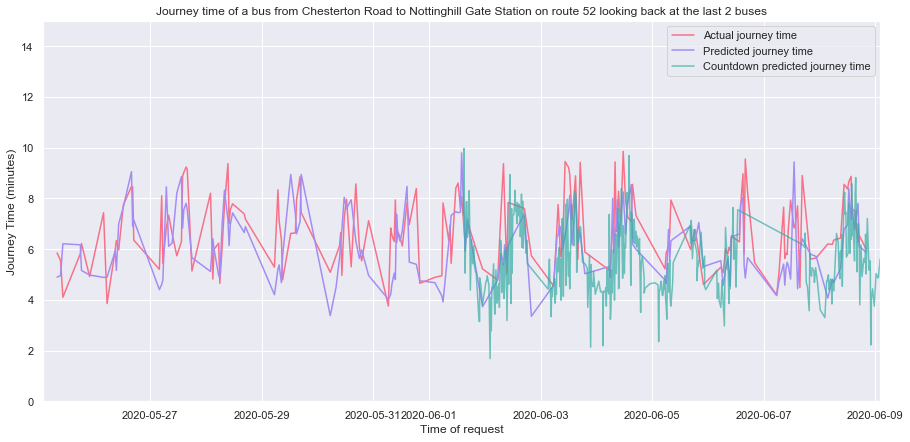

In [390]:
times_52_2b = [convert_time_to_datetime(t) for t in req_timesx_52_2b]
actual_jrny_52_2b = [x.total_seconds() for x in accs_jrny_52_2b]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_52_2b, actual_jrny_52_2b, label="Actual journey time")
ax.plot(times_52_2b, preds_jrny_52_2b, label="Predicted journey time", color=cs[6])
ax.plot(tfl_times, tfl_preds_52, label="Countdown predicted journey time", color=cs[4], alpha=0.7)
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_ylim(0, 15)
ax.set_xlim([dt.datetime(2020, 5, 25, 2), dt.datetime(2020, 6, 9, 2)])
ax.set_title("Journey time of a bus from Chesterton Road to Nottinghill Gate Station on route 52 looking back at the last 2 buses")
ax.legend()

plt.show()

In [391]:
# looking at journeys in the past 5 buses
_, _, req_timesx_52_5b, preds_jrny_52_5b, accs_jrny_52_5b = eval_historical_model(0, 5, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 10 buses
_, _, req_timesx_52_10b, preds_jrny_52_10b, accs_jrny_52_10b = eval_historical_model(0, 10, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 15 buses
_, _, req_timesx_52_15b, preds_jrny_52_15b, accs_jrny_52_15b = eval_historical_model(0, 15, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-25 02:00:00
Predicted journey time is  4.813605442176869
There are no buses due at this time from this stop
Request time is  2020-05-25 02:30:00
Predicted journey time is  4.813605442176869
There are no buses due at this time from this stop
Request time is  2020-05-25 03:00:00
Predicted journey time is  4.813605442176869
There are no buses due at this time from this stop
Request time is  2020-05-25 03:30:00
Predicted journey time is  4.906802721088435
There are no buses due at this time from this stop
Request time is  2020-05-25 04:00:00
Predicted journey time is  4.909183673469387
There are no buses due at this time from this stop
Request time is  2020-05-25 04:30:00
Predicted journey time is  4.699659863945579
There are no buses due at this time from this stop
Request time is  2020-05-25 05:00:00
Predicted journey time is  4.997959183673469
There are no buses due at this time from this stop
Request time is  2020-05-25 05:30:00
Predicted journey time is  4.191

Predicted journey time is  7.318367346938775
Request time is  2020-05-26 14:00:00
Predicted journey time is  7.181292517006804
There are no buses due at this time from this stop
Request time is  2020-05-26 14:30:00
Predicted journey time is  6.793537414965987
Request time is  2020-05-26 15:00:00
Predicted journey time is  7.164625850340135
There are no buses due at this time from this stop
Request time is  2020-05-26 15:30:00
Predicted journey time is  7.078231292517006
There are no buses due at this time from this stop
Request time is  2020-05-26 16:00:00
Predicted journey time is  7.889795918367346
Actual journey time is 0:08:28
Request time is  2020-05-26 16:30:00
Predicted journey time is  7.885714285714285
Actual journey time is 0:08:27
Request time is  2020-05-26 17:00:00
Predicted journey time is  7.204421768707482
Actual journey time is 0:06:21
Request time is  2020-05-26 17:30:00
Predicted journey time is  6.586394557823129
There are no buses due at this time from this stop
Re

Predicted journey time is  5.070748299319728
Actual journey time is 0:08:12
Request time is  2020-05-28 02:30:00
Predicted journey time is  5.65374149659864
There are no buses due at this time from this stop
Request time is  2020-05-28 03:00:00
Predicted journey time is  5.65374149659864
Actual journey time is 0:04:49
Request time is  2020-05-28 03:30:00
Predicted journey time is  5.4190476190476184
Actual journey time is 0:05:59
Request time is  2020-05-28 04:00:00
Predicted journey time is  5.358163265306121
There are no buses due at this time from this stop
Request time is  2020-05-28 04:30:00
Predicted journey time is  4.617006802721089
There are no buses due at this time from this stop
Request time is  2020-05-28 05:00:00
Predicted journey time is  4.409863945578231
There are no buses due at this time from this stop
Request time is  2020-05-28 05:30:00
Predicted journey time is  4.727210884353741
Actual journey time is 0:06:14
Request time is  2020-05-28 06:00:00
Predicted journey

Predicted journey time is  7.485034013605443
There are no buses due at this time from this stop
Request time is  2020-05-29 14:00:00
Predicted journey time is  7.815646258503402
There are no buses due at this time from this stop
Request time is  2020-05-29 14:30:00
Predicted journey time is  7.530952380952382
Actual journey time is 0:06:38
Request time is  2020-05-29 15:00:00
Predicted journey time is  7.147959183673469
Actual journey time is 0:07:56
Request time is  2020-05-29 15:30:00
Predicted journey time is  7.187074829931972
There are no buses due at this time from this stop
Request time is  2020-05-29 16:00:00
Predicted journey time is  7.411224489795917
Request time is  2020-05-29 16:30:00
Predicted journey time is  7.241836734693878
Actual journey time is 0:08:51
Request time is  2020-05-29 17:00:00
Predicted journey time is  7.997278911564626
Actual journey time is 0:07:26
Request time is  2020-05-29 17:30:00
Predicted journey time is  7.671768707482994
There are no buses due

Predicted journey time is  4.695238095238095
Request time is  2020-05-31 00:30:00
Predicted journey time is  4.695238095238095
Request time is  2020-05-31 01:00:00
Predicted journey time is  4.695238095238095
Request time is  2020-05-31 01:30:00
Predicted journey time is  4.695238095238095
Request time is  2020-05-31 02:00:00
Predicted journey time is  4.695238095238095
Request time is  2020-05-31 02:30:00
Predicted journey time is  4.695238095238095
Request time is  2020-05-31 03:00:00
Predicted journey time is  4.695238095238095
Request time is  2020-05-31 03:30:00
Predicted journey time is  4.532993197278912
There are no buses due at this time from this stop
Request time is  2020-05-31 04:00:00
Predicted journey time is  3.862925170068027
There are no buses due at this time from this stop
Request time is  2020-05-31 04:30:00
Predicted journey time is  4.061904761904762
There are no buses due at this time from this stop
Request time is  2020-05-31 05:00:00
Predicted journey time is  

Predicted journey time is  7.344557823129252
Actual journey time is 0:08:36
Request time is  2020-06-01 13:00:00
Predicted journey time is  7.656802721088436
There are no buses due at this time from this stop
Request time is  2020-06-01 13:30:00
Predicted journey time is  7.649659863945577
Actual journey time is 0:07:37
Request time is  2020-06-01 14:00:00
Predicted journey time is  8.452380952380953
Actual journey time is 0:08:04
Request time is  2020-06-01 14:30:00
Predicted journey time is  8.960204081632652
There are no buses due at this time from this stop
Request time is  2020-06-01 15:00:00
Predicted journey time is  9.13469387755102
There are no buses due at this time from this stop
Request time is  2020-06-01 15:30:00
Predicted journey time is  7.823809523809522
Actual journey time is 0:06:16
Request time is  2020-06-01 16:00:00
Predicted journey time is  6.682312925170069
There are no buses due at this time from this stop
Request time is  2020-06-01 16:30:00
Predicted journey

Request time is  2020-06-03 02:30:00
Predicted journey time is  5.0666666666666655
Request time is  2020-06-03 03:00:00
Predicted journey time is  5.369047619047619
There are no buses due at this time from this stop
Request time is  2020-06-03 03:30:00
Predicted journey time is  4.858163265306122
There are no buses due at this time from this stop
Request time is  2020-06-03 04:00:00
Predicted journey time is  4.0476190476190474
There are no buses due at this time from this stop
Request time is  2020-06-03 04:30:00
Predicted journey time is  3.3741496598639458
There are no buses due at this time from this stop
Request time is  2020-06-03 05:00:00
Predicted journey time is  4.505102040816327
There are no buses due at this time from this stop
Request time is  2020-06-03 05:30:00
Predicted journey time is  4.7870748299319725
Actual journey time is 0:04:33
Request time is  2020-06-03 06:00:00
Predicted journey time is  4.741156462585034
Actual journey time is 0:05:08
Request time is  2020-0

Predicted journey time is  6.963265306122449
There are no buses due at this time from this stop
Request time is  2020-06-04 13:30:00
Predicted journey time is  7.299319727891156
Actual journey time is 0:07:15
Request time is  2020-06-04 14:00:00
Predicted journey time is  7.144217687074829
Request time is  2020-06-04 14:30:00
Predicted journey time is  7.631972789115647
There are no buses due at this time from this stop
Request time is  2020-06-04 15:00:00
Predicted journey time is  7.955442176870748
Actual journey time is 0:07:05
Request time is  2020-06-04 15:30:00
Predicted journey time is  7.1268707482993205
Actual journey time is 0:08:33
Request time is  2020-06-04 16:00:00
Predicted journey time is  6.581632653061225
There are no buses due at this time from this stop
Request time is  2020-06-04 16:30:00
Predicted journey time is  6.8309523809523816
There are no buses due at this time from this stop
Request time is  2020-06-04 17:00:00
Predicted journey time is  6.479931972789116


Predicted journey time is  4.694557823129252
There are no buses due at this time from this stop
Request time is  2020-06-06 03:00:00
Predicted journey time is  4.694557823129252
There are no buses due at this time from this stop
Request time is  2020-06-06 03:30:00
Predicted journey time is  4.633333333333335
There are no buses due at this time from this stop
Request time is  2020-06-06 04:00:00
Predicted journey time is  4.748639455782312
There are no buses due at this time from this stop
Request time is  2020-06-06 04:30:00
Predicted journey time is  4.825510204081634
There are no buses due at this time from this stop
Request time is  2020-06-06 05:00:00
Predicted journey time is  4.108843537414966
There are no buses due at this time from this stop
Request time is  2020-06-06 05:30:00
Predicted journey time is  4.575850340136055
Actual journey time is 0:05:17
Request time is  2020-06-06 06:00:00
Predicted journey time is  4.702721088435374
There are no buses due at this time from thi

Predicted journey time is  6.033673469387755
Request time is  2020-06-07 14:30:00
Predicted journey time is  5.98843537414966
Actual journey time is 0:07:42
Request time is  2020-06-07 15:00:00
Predicted journey time is  5.861904761904763
There are no buses due at this time from this stop
Request time is  2020-06-07 15:30:00
Predicted journey time is  6.341836734693877
Actual journey time is 0:04:29
Request time is  2020-06-07 16:00:00
Predicted journey time is  5.68843537414966
There are no buses due at this time from this stop
Request time is  2020-06-07 16:30:00
Predicted journey time is  5.8986394557823125
Actual journey time is 0:08:54
Request time is  2020-06-07 17:00:00
Predicted journey time is  6.26530612244898
There are no buses due at this time from this stop
Request time is  2020-06-07 17:30:00
Predicted journey time is  6.26530612244898
Request time is  2020-06-07 18:00:00
Predicted journey time is  6.26530612244898
Request time is  2020-06-07 18:30:00
Predicted journey ti

Predicted journey time is  5.02704402515723
There are no buses due at this time from this stop
Request time is  2020-05-25 05:30:00
Predicted journey time is  4.2748427672955955
There are no buses due at this time from this stop
Request time is  2020-05-25 06:00:00
Predicted journey time is  4.349056603773585
Request time is  2020-05-25 06:30:00
Predicted journey time is  4.436163522012578
There are no buses due at this time from this stop
Request time is  2020-05-25 07:00:00
Predicted journey time is  4.576415094339621
There are no buses due at this time from this stop
Request time is  2020-05-25 07:30:00
Predicted journey time is  4.576415094339621
There are no buses due at this time from this stop
Request time is  2020-05-25 08:00:00
Predicted journey time is  4.656603773584905
Actual journey time is 0:05:51
Request time is  2020-05-25 08:30:00
Predicted journey time is  4.449371069182389
Request time is  2020-05-25 09:00:00
Predicted journey time is  4.204402515723269
Request time 

Predicted journey time is  6.833962264150941
There are no buses due at this time from this stop
Request time is  2020-05-26 18:00:00
Predicted journey time is  6.833962264150941
Request time is  2020-05-26 18:30:00
Predicted journey time is  5.41194968553459
There are no buses due at this time from this stop
Request time is  2020-05-26 19:00:00
Predicted journey time is  5.110377358490565
There are no buses due at this time from this stop
Request time is  2020-05-26 19:30:00
Predicted journey time is  5.110377358490565
There are no buses due at this time from this stop
Request time is  2020-05-26 20:00:00
Predicted journey time is  5.110377358490565
There are no buses due at this time from this stop
Request time is  2020-05-26 20:30:00
Predicted journey time is  5.110377358490565
There are no buses due at this time from this stop
Request time is  2020-05-26 21:00:00
Predicted journey time is  5.110377358490565
There are no buses due at this time from this stop
Request time is  2020-05-

Predicted journey time is  4.735849056603772
Actual journey time is 0:06:14
Request time is  2020-05-28 06:00:00
Predicted journey time is  4.916352201257861
Actual journey time is 0:04:39
Request time is  2020-05-28 06:30:00
Predicted journey time is  4.938993710691823
There are no buses due at this time from this stop
Request time is  2020-05-28 07:00:00
Predicted journey time is  6.032389937106917
Actual journey time is 0:06:05
Request time is  2020-05-28 07:30:00
Predicted journey time is  6.043081761006288
There are no buses due at this time from this stop
Request time is  2020-05-28 08:00:00
Predicted journey time is  6.926729559748426
Actual journey time is 0:07:43
Request time is  2020-05-28 08:30:00
Predicted journey time is  6.82201257861635
There are no buses due at this time from this stop
Request time is  2020-05-28 09:00:00
Predicted journey time is  7.440566037735847
Request time is  2020-05-28 09:30:00
Predicted journey time is  7.3349056603773555
Actual journey time is

Predicted journey time is  7.958490566037734
Actual journey time is 0:07:26
Request time is  2020-05-29 17:30:00
Predicted journey time is  7.591509433962261
There are no buses due at this time from this stop
Request time is  2020-05-29 18:00:00
Predicted journey time is  7.591509433962261
There are no buses due at this time from this stop
Request time is  2020-05-29 18:30:00
Predicted journey time is  7.591509433962261
There are no buses due at this time from this stop
Request time is  2020-05-29 19:00:00
Predicted journey time is  7.591509433962261
There are no buses due at this time from this stop
Request time is  2020-05-29 19:30:00
Predicted journey time is  7.591509433962261
Request time is  2020-05-29 20:00:00
Predicted journey time is  7.591509433962261
Request time is  2020-05-29 20:30:00
Predicted journey time is  7.591509433962261
Request time is  2020-05-29 21:00:00
Predicted journey time is  7.591509433962261
Request time is  2020-05-29 21:30:00
Predicted journey time is  

Predicted journey time is  4.20754716981132
There are no buses due at this time from this stop
Request time is  2020-05-31 05:00:00
Predicted journey time is  4.332075471698113
There are no buses due at this time from this stop
Request time is  2020-05-31 05:30:00
Predicted journey time is  4.2132075471698105
There are no buses due at this time from this stop
Request time is  2020-05-31 06:00:00
Predicted journey time is  4.2808176100628925
There are no buses due at this time from this stop
Request time is  2020-05-31 06:30:00
Predicted journey time is  4.156603773584903
Actual journey time is 0:03:45
Request time is  2020-05-31 07:00:00
Predicted journey time is  4.140566037735848
There are no buses due at this time from this stop
Request time is  2020-05-31 07:30:00
Predicted journey time is  4.132389937106918
Actual journey time is 0:06:50
Request time is  2020-05-31 08:00:00
Predicted journey time is  4.618867924528301
Actual journey time is 0:06:33
Request time is  2020-05-31 08:3

Predicted journey time is  7.243396226415092
There are no buses due at this time from this stop
Request time is  2020-06-01 16:30:00
Predicted journey time is  7.2776729559748405
Actual journey time is 0:07:04
Request time is  2020-06-01 17:00:00
Predicted journey time is  6.836163522012577
There are no buses due at this time from this stop
Request time is  2020-06-01 17:30:00
Predicted journey time is  6.372955974842765
There are no buses due at this time from this stop
Request time is  2020-06-01 18:00:00
Predicted journey time is  6.309119496855344
Request time is  2020-06-01 18:30:00
Predicted journey time is  6.309119496855344
Request time is  2020-06-01 19:00:00
Predicted journey time is  6.309119496855344
Request time is  2020-06-01 19:30:00
Predicted journey time is  6.11698113207547
Request time is  2020-06-01 20:00:00
Predicted journey time is  6.11698113207547
Request time is  2020-06-01 20:30:00
Predicted journey time is  6.11698113207547
Request time is  2020-06-01 21:00:0

Predicted journey time is  4.720440251572325
Actual journey time is 0:05:08
Request time is  2020-06-03 06:30:00
Predicted journey time is  5.2289308176100615
There are no buses due at this time from this stop
Request time is  2020-06-03 07:00:00
Predicted journey time is  5.837735849056601
Actual journey time is 0:06:50
Request time is  2020-06-03 07:30:00
Predicted journey time is  6.172012578616351
Actual journey time is 0:07:45
Request time is  2020-06-03 08:00:00
Predicted journey time is  6.687421383647797
Actual journey time is 0:06:55
Request time is  2020-06-03 08:30:00
Predicted journey time is  6.657232704402514
Actual journey time is 0:05:42
Request time is  2020-06-03 09:00:00
Predicted journey time is  6.425471698113205
Request time is  2020-06-03 09:30:00
Predicted journey time is  6.2849056603773565
Actual journey time is 0:06:12
Request time is  2020-06-03 10:00:00
Predicted journey time is  6.535534591194968
There are no buses due at this time from this stop
Request t

Predicted journey time is  6.439308176100628
Actual journey time is 0:07:19
Request time is  2020-06-04 17:30:00
Predicted journey time is  6.716666666666665
There are no buses due at this time from this stop
Request time is  2020-06-04 18:00:00
Predicted journey time is  6.709433962264148
There are no buses due at this time from this stop
Request time is  2020-06-04 18:30:00
Predicted journey time is  6.709433962264148
There are no buses due at this time from this stop
Request time is  2020-06-04 19:00:00
Predicted journey time is  6.752515723270439
Request time is  2020-06-04 19:30:00
Predicted journey time is  6.752515723270439
Request time is  2020-06-04 20:00:00
Predicted journey time is  6.752515723270439
Request time is  2020-06-04 20:30:00
Predicted journey time is  6.752515723270439
Request time is  2020-06-04 21:00:00
Predicted journey time is  6.407861635220124
Request time is  2020-06-04 21:30:00
Predicted journey time is  6.033962264150942
There are no buses due at this ti

Predicted journey time is  4.5364779874213825
There are no buses due at this time from this stop
Request time is  2020-06-06 06:30:00
Predicted journey time is  4.426729559748426
Actual journey time is 0:05:04
Request time is  2020-06-06 07:00:00
Predicted journey time is  4.309748427672956
There are no buses due at this time from this stop
Request time is  2020-06-06 07:30:00
Predicted journey time is  4.6572327044025155
Actual journey time is 0:06:00
Request time is  2020-06-06 08:00:00
Predicted journey time is  5.3654088050314455
Request time is  2020-06-06 08:30:00
Predicted journey time is  5.494025157232703
Actual journey time is 0:05:48
Request time is  2020-06-06 09:00:00
Predicted journey time is  5.321069182389935
Actual journey time is 0:06:04
Request time is  2020-06-06 09:30:00
Predicted journey time is  5.072955974842766
Actual journey time is 0:05:57
Request time is  2020-06-06 10:00:00
Predicted journey time is  5.6424528301886765
Actual journey time is 0:06:31
Request

Request time is  2020-06-07 18:00:00
Predicted journey time is  6.055974842767294
Request time is  2020-06-07 18:30:00
Predicted journey time is  6.055974842767294
Request time is  2020-06-07 19:00:00
Predicted journey time is  6.055974842767294
Request time is  2020-06-07 19:30:00
Predicted journey time is  5.987106918238992
Request time is  2020-06-07 20:00:00
Predicted journey time is  5.843081761006287
Actual journey time is 0:05:36
Request time is  2020-06-07 20:30:00
Predicted journey time is  5.778301886792452
There are no buses due at this time from this stop
Request time is  2020-06-07 21:00:00
Predicted journey time is  5.415094339622641
There are no buses due at this time from this stop
Request time is  2020-06-07 21:30:00
Predicted journey time is  5.452201257861634
Request time is  2020-06-07 22:00:00
Predicted journey time is  5.452201257861634
Request time is  2020-06-07 22:30:00
Predicted journey time is  5.66446540880503
Actual journey time is 0:05:39
Request time is  

Predicted journey time is  4.499726775956285
Request time is  2020-05-25 09:00:00
Predicted journey time is  4.382786885245903
Request time is  2020-05-25 09:30:00
Predicted journey time is  4.5434426229508205
Actual journey time is 0:05:33
Request time is  2020-05-25 10:00:00
Predicted journey time is  4.697540983606557
There are no buses due at this time from this stop
Request time is  2020-05-25 10:30:00
Predicted journey time is  5.3183060109289615
Actual journey time is 0:04:06
Request time is  2020-05-25 11:00:00
Predicted journey time is  5.6259562841530055
There are no buses due at this time from this stop
Request time is  2020-05-25 11:30:00
Predicted journey time is  6.224043715846994
There are no buses due at this time from this stop
Request time is  2020-05-25 12:00:00
Predicted journey time is  6.255464480874318
Request time is  2020-05-25 12:30:00
Predicted journey time is  6.255464480874318
Request time is  2020-05-25 13:00:00
Predicted journey time is  6.396994535519126

Predicted journey time is  5.640163934426229
There are no buses due at this time from this stop
Request time is  2020-05-26 21:30:00
Predicted journey time is  5.640163934426229
There are no buses due at this time from this stop
Request time is  2020-05-26 22:00:00
Predicted journey time is  5.640163934426229
There are no buses due at this time from this stop
Request time is  2020-05-26 22:30:00
Predicted journey time is  5.640163934426229
There are no buses due at this time from this stop
Request time is  2020-05-26 23:00:00
Predicted journey time is  5.640163934426229
Request time is  2020-05-26 23:30:00
Predicted journey time is  5.640163934426229
Request time is  2020-05-27 00:00:00
Predicted journey time is  5.640163934426229
Request time is  2020-05-27 00:30:00
Predicted journey time is  5.640163934426229
Request time is  2020-05-27 01:00:00
Predicted journey time is  5.640163934426229
Request time is  2020-05-27 01:30:00
Predicted journey time is  5.640163934426229
Request time 

Predicted journey time is  7.256284153005464
Request time is  2020-05-28 09:30:00
Predicted journey time is  6.993442622950819
Actual journey time is 0:09:22
Request time is  2020-05-28 10:00:00
Predicted journey time is  6.924043715846995
Actual journey time is 0:07:01
Request time is  2020-05-28 10:30:00
Predicted journey time is  6.81448087431694
Actual journey time is 0:07:33
Request time is  2020-05-28 11:00:00
Predicted journey time is  6.6784153005464475
There are no buses due at this time from this stop
Request time is  2020-05-28 11:30:00
Predicted journey time is  6.829234972677594
Actual journey time is 0:07:47
Request time is  2020-05-28 12:00:00
Predicted journey time is  7.095081967213113
There are no buses due at this time from this stop
Request time is  2020-05-28 12:30:00
Predicted journey time is  6.9622950819672145
Request time is  2020-05-28 13:00:00
Predicted journey time is  6.9622950819672145
Request time is  2020-05-28 13:30:00
Predicted journey time is  6.96229

Predicted journey time is  7.537431693989071
Request time is  2020-05-29 21:30:00
Predicted journey time is  7.537431693989071
Request time is  2020-05-29 22:00:00
Predicted journey time is  7.537431693989071
Request time is  2020-05-29 22:30:00
Predicted journey time is  6.982513661202186
There are no buses due at this time from this stop
Request time is  2020-05-29 23:00:00
Predicted journey time is  6.982513661202186
There are no buses due at this time from this stop
Request time is  2020-05-29 23:30:00
Predicted journey time is  6.469945355191259
There are no buses due at this time from this stop
Request time is  2020-05-30 00:00:00
Predicted journey time is  6.469945355191259
There are no buses due at this time from this stop
Request time is  2020-05-30 00:30:00
Predicted journey time is  6.469945355191259
There are no buses due at this time from this stop
Request time is  2020-05-30 01:00:00
Predicted journey time is  6.469945355191259
There are no buses due at this time from thi

Predicted journey time is  4.483879781420765
Actual journey time is 0:06:33
Request time is  2020-05-31 08:30:00
Predicted journey time is  4.798360655737705
There are no buses due at this time from this stop
Request time is  2020-05-31 09:00:00
Predicted journey time is  4.853278688524589
Actual journey time is 0:06:18
Request time is  2020-05-31 09:30:00
Predicted journey time is  4.952732240437159
Actual journey time is 0:07:56
Request time is  2020-05-31 10:00:00
Predicted journey time is  5.969125683060111
Actual journey time is 0:06:15
Request time is  2020-05-31 10:30:00
Predicted journey time is  6.277322404371585
Actual journey time is 0:06:42
Request time is  2020-05-31 11:00:00
Predicted journey time is  6.482513661202186
There are no buses due at this time from this stop
Request time is  2020-05-31 11:30:00
Predicted journey time is  6.443442622950821
Actual journey time is 0:06:28
Request time is  2020-05-31 12:00:00
Predicted journey time is  6.506010928961748
Request tim

Predicted journey time is  6.304371584699454
Request time is  2020-06-01 21:00:00
Predicted journey time is  6.304371584699454
Request time is  2020-06-01 21:30:00
Predicted journey time is  6.304371584699454
Request time is  2020-06-01 22:00:00
Predicted journey time is  5.775409836065574
There are no buses due at this time from this stop
Request time is  2020-06-01 22:30:00
Predicted journey time is  5.775409836065574
Request time is  2020-06-01 23:00:00
Predicted journey time is  5.526775956284153
Actual journey time is 0:05:13
Request time is  2020-06-01 23:30:00
Predicted journey time is  5.4612021857923505
There are no buses due at this time from this stop
Request time is  2020-06-02 00:00:00
Predicted journey time is  5.4612021857923505
Request time is  2020-06-02 00:30:00
Predicted journey time is  5.4612021857923505
Request time is  2020-06-02 01:00:00
Predicted journey time is  5.4612021857923505
Request time is  2020-06-02 01:30:00
Predicted journey time is  5.46120218579235

Predicted journey time is  6.5439890710382524
There are no buses due at this time from this stop
Request time is  2020-06-03 10:30:00
Predicted journey time is  6.634426229508197
Actual journey time is 0:09:27
Request time is  2020-06-03 11:00:00
Predicted journey time is  6.626775956284153
There are no buses due at this time from this stop
Request time is  2020-06-03 11:30:00
Predicted journey time is  7.563661202185792
There are no buses due at this time from this stop
Request time is  2020-06-03 12:00:00
Predicted journey time is  7.443169398907104
Actual journey time is 0:09:13
Request time is  2020-06-03 12:30:00
Predicted journey time is  7.865300546448088
Actual journey time is 0:08:57
Request time is  2020-06-03 13:00:00
Predicted journey time is  7.991803278688525
There are no buses due at this time from this stop
Request time is  2020-06-03 13:30:00
Predicted journey time is  7.551912568306013
Actual journey time is 0:07:10
Request time is  2020-06-03 14:00:00
Predicted journ

Predicted journey time is  6.4830601092896165
Request time is  2020-06-04 21:30:00
Predicted journey time is  6.2390710382513666
There are no buses due at this time from this stop
Request time is  2020-06-04 22:00:00
Predicted journey time is  6.2390710382513666
There are no buses due at this time from this stop
Request time is  2020-06-04 22:30:00
Predicted journey time is  6.2390710382513666
There are no buses due at this time from this stop
Request time is  2020-06-04 23:00:00
Predicted journey time is  6.2390710382513666
There are no buses due at this time from this stop
Request time is  2020-06-04 23:30:00
Predicted journey time is  5.974590163934427
There are no buses due at this time from this stop
Request time is  2020-06-05 00:00:00
Predicted journey time is  5.974590163934427
There are no buses due at this time from this stop
Request time is  2020-06-05 00:30:00
Predicted journey time is  5.974590163934427
There are no buses due at this time from this stop
Request time is  20

Actual journey time is 0:05:57
Request time is  2020-06-06 10:00:00
Predicted journey time is  5.592622950819672
Actual journey time is 0:06:31
Request time is  2020-06-06 10:30:00
Predicted journey time is  5.882786885245902
There are no buses due at this time from this stop
Request time is  2020-06-06 11:00:00
Predicted journey time is  7.289890710382514
There are no buses due at this time from this stop
Request time is  2020-06-06 11:30:00
Predicted journey time is  7.240983606557377
There are no buses due at this time from this stop
Request time is  2020-06-06 12:00:00
Predicted journey time is  7.260109289617487
There are no buses due at this time from this stop
Request time is  2020-06-06 12:30:00
Predicted journey time is  7.661748633879783
There are no buses due at this time from this stop
Request time is  2020-06-06 13:00:00
Predicted journey time is  7.638524590163933
Request time is  2020-06-06 13:30:00
Predicted journey time is  7.184699453551914
Actual journey time is 0:06

Request time is  2020-06-07 22:30:00
Predicted journey time is  5.630327868852459
Actual journey time is 0:05:39
Request time is  2020-06-07 23:00:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-07 23:30:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-08 00:00:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-08 00:30:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-08 01:00:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-08 01:30:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-08 02:00:00
Predicted journey time is  5.490983606557377
Request time is  2020-06-08 02:30:00
Predicted journey time is  5.149453551912569
There are no buses due at this time from this stop
Request time is  2020-06-08 03:00:00
Predicted journey time is  5.098360655737705
There are no buses due at this time from this stop
Request time is  2020-06-08 03:30:00
Predicted 

In [392]:
print(len(preds_jrny_52_5b), len(preds_jrny_52_10b), len(preds_jrny_52_15b))

180 180 180


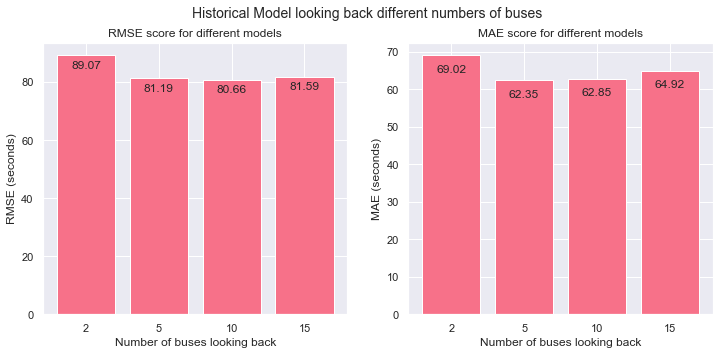

In [458]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_jrny_preds_52 = [preds_jrny_52_2b, preds_jrny_52_5b, preds_jrny_52_10b, preds_jrny_52_15b]
all_jrny_accs_52 = [accs_jrny_52_2b, accs_jrny_52_5b, accs_jrny_52_10b, accs_jrny_52_15b]

mapes_52b = []
rmses_52b = []

for i, buses_back in enumerate(all_jrny_preds_52): 
    
    actual_seconds = [(a.total_seconds() * 60) for a in all_jrny_accs_52[i]]
    predicted_seconds = [p * 60 for p in buses_back]

    mape52 = mean_absolute_error(actual_seconds, predicted_seconds)
    mse52 = mean_squared_error(actual_seconds, predicted_seconds)
    rmse52 = np.sqrt(mse52)

    mapes_52b.append(mape52)
    rmses_52b.append(rmse52)
    
buses_back_labels = ["2", "5", "10", "15"]

fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].bar(buses_back_labels, rmses_52b)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Number of buses looking back")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmseb = [round(rmses_52b[0], 2), round(rmses_52b[1], 2), round(rmses_52b[2], 2), round(rmses_52b[3], 2)]

for rect, label in zip(rects_rmse, labels_rmseb):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(buses_back_labels, mapes_52b)
ax[1].set_title("MAE score for different models")
ax[1].set_xlabel("Number of buses looking back")
ax[1].set_ylabel("MAE (seconds)")

rects_mape = ax[1].patches
labels_mapeb = [round(mapes_52b[0], 2), round(mapes_52b[1], 2), round(mapes_52b[2], 2), round(mapes_52b[3], 2)]

for rect, label in zip(rects_mape, labels_mapeb):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back different numbers of buses', fontsize=14)
plt.show()

### Compare all 8 models against each other

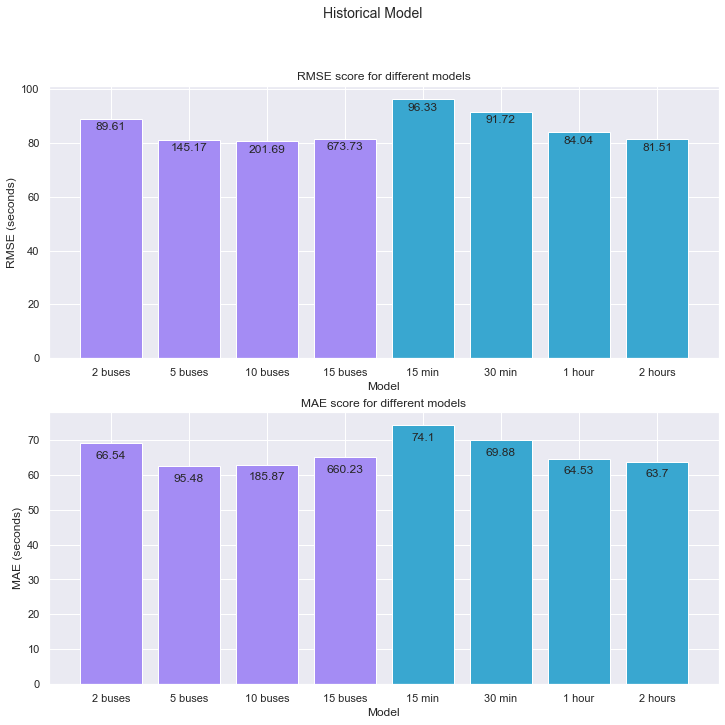

In [457]:
compare_labels = ["2 buses", "5 buses", "10 buses", "15 buses", "15 min", "30 min", "1 hour", "2 hours"]
rmses_compare = rmses_52b + rmses_52m
mapes_compare = mapes_52b + mapes_52m
colour_map = [cs[6], cs[6], cs[6], cs[6], cs[5], cs[5], cs[5], cs[5]]

fig, ax = plt.subplots(figsize=(12,11), nrows = 2, ncols = 1)

# different colours for buses back bersus time back
ax[0].bar(compare_labels, rmses_compare, color=colour_map)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Model")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmse = labels_rmseb + labels_rmsem

for rect, label in zip(rects_rmse, labels_rmse):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(compare_labels, mapes_compare, color=colour_map)
ax[1].set_title("MAE score for different models")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("MAE (seconds)")

rects_mape = ax[1].patches
labels_mape = labels_mapeb + labels_mapem

for rect, label in zip(rects_mape, labels_mape):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model', fontsize=14)
plt.show()

### Store values for global evaluation

In [395]:
historical_mapes = mapes_compare
historical_rmses = rmses_compare

%store historical_mapes historical_rmses

Stored 'historical_mapes' (list)
Stored 'historical_rmses' (list)


CONCLUSIONS: According to both the MAPE and RMSE, the best model is the model that looks back at the journey times of the last 15 buses.

### Different gaps for predictions for bus route 52

Test the best model (i.e. looking back 15 buses) on gaps of varying sizes (from gap of size 5 up to gap of size 30).

Then to make sure, test the 2nd, 3rd and 4th best models too i.e.

- looking back 10 buses
- looking back 5 buses
- looking back 120 minutes.

In [447]:
def get_actual_times_gap(arr_stop, req_time, bus_to_track, arr_stop_id, gap):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    - size of gap between stops
    
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    min_time = 0
    max_time = 15
    
    if (gap > 5) and (gap <= 10):
        min_time = 5
        max_time = 30
    elif (gap > 10) and (gap <= 15):
        min_time = 15
        max_time = 40
    elif (gap > 15) and (gap <= 20):
        min_time = 20
        max_time = 50
    elif (gap > 20) and (gap <= 25):
        min_time = 35
        max_time = 65
    elif (gap > 25) and (gap <= 30):
        min_time = 40
        max_time = 75
    elif (gap > 30):
        min_time = 40
        max_time = 90
    
    [bus_id, a_id, date, _, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            print("Arrives: {}, Req time: {}".format(actual_arr_time, req_time))
            
            if actual_arr_time > req_time:
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                if (actual_jrny_time > dt.timedelta(minutes = max_time)) or (actual_jrny_time < dt.timedelta(minutes = min_time)):
                    return -1, -1
                
                print("Valid journey length {}".format(actual_jrny_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [448]:
def pred_eval_times_gap(req_time, stop_a, stop_b, a_id, b_id, buses_back, time_back, gap):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time and journey time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B, as well as the
    predicted and actual journey time of a bus from stop A to stop B in seconds.
    
    If the actual bus data cannot be found, return 0s all around.
    
    """
    
    pred_jrny_time = 0
    if buses_back == -1:
        # option 1) look back x hours
        pred_jrny_time, most_recent_left = predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back)
    else:
        # option 2) look back x buses TODO
        pred_jrny_time, most_recent_left = predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back)
        
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        # Can't find any journeys
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        # Can't find correlating leaving bus
        return pred_arr, 0, 0, 0
    
    actual_arr, actual_jrny_time = get_actual_times_gap(stop_b, req_time, bus_to_track, b_id, gap)
    
    if actual_arr == -1:
        # There is no bus arriving at req_time
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

In [412]:
print("Number of stops in route 52: ", len(stops_in_sequence_inbound.get("52")))
stop_a_gaps = stops_in_sequence_inbound.get("52")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_inbound.get("52")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_inbound.get("52")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_inbound.get("52")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_inbound.get("52")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_inbound.get("52")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_inbound.get("52")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_inbound.get("52")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_15, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a_gaps)
print("destination stops: ", destination_stops)

Number of stops in route 52:  37
origin stop:  Willesden Bus Garage
destination stops:  ['Okehampton Road', 'Harrow Road / Kilburn Lane', 'Chesterton Road', 'Notting Hill Gate Station', 'Palace Gate', 'Knightsbridge Station  / Harrods', 'Victoria Bus Station']


In [413]:
stop_a_entries = b_52.loc[(b_52['bus_stop_name'] == stop_a_gaps) & (b_52['direction'] == 'inbound')]
[_, stop_a_id_gaps, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id_gaps)

(1208, 5)
490014687E


In [414]:
temp_52_a1 = new_52.loc[(new_52['bus_stop_id'] == '490014687E') & (new_52['direction'] == 'inbound')]
temp_52_a1['bus_stop_name'] = "Willesden Bus Garage"
temp_52_a1 = temp_52_a1.drop(columns = "bus_stop_id")

stop_a_entries = stop_a_entries.append(temp_52_a1)
print(stop_a_entries.shape)

/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2498, 5)


In [415]:
stop_bs_updated = []
b_ids = []

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == end) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    temp_52_b1 = new_52.loc[(new_52['bus_stop_id'] == stop_b_id_gaps) & (new_52['direction'] == 'inbound')]
    temp_52_b1['bus_stop_name'] = end
    temp_52_b1 = temp_52_b1.drop(columns = "bus_stop_id")

    stop_b_entries = stop_b_entries.append(temp_52_b1)
    stop_bs_updated.append(stop_b_entries)
    b_ids.append(stop_b_id_gaps)
    print(stop_b_entries.shape)

/Users/serenechongtrakul/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


(2698, 5)
(2699, 5)
(2760, 5)
(2767, 5)
(1373, 5)
(2732, 5)
(2675, 5)


### Looking back 5 buses

In [438]:
stop_a_entries = stop_a_entries.reset_index()
stop_a_entries

,index,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,21812,Willesden Bus Garage,2020-05-27 05:17:03,19668_490014687E_2020-05-27_inbound_1,2020-05-27 05:16:54.979,inbound
1,21879,Willesden Bus Garage,2020-05-27 05:25:50,11545_490014687E_2020-05-27_inbound_0,2020-05-27 05:25:13.343,inbound
2,21903,Willesden Bus Garage,2020-05-27 05:33:59,10581_490014687E_2020-05-27_inbound_0,2020-05-27 05:33:10.723,inbound
3,21960,Willesden Bus Garage,2020-05-27 05:41:13,10629_490014687E_2020-05-27_inbound_0,2020-05-27 05:16:54.979,inbound
4,22015,Willesden Bus Garage,2020-05-27 05:53:09,10268_490014687E_2020-05-27_inbound_1,2020-05-27 05:25:13.343,inbound
...,...,...,...,...,...,...
993,94247,Willesden Bus Garage,2020-06-09 08:51:37,19417_490014687E_2020-06-09_inbound_0,2020-06-09 08:32:40.178,inbound
994,94361,Willesden Bus Garage,2020-06-09 09:01:50,19669_490014687E_2020-06-09_inbound_1,2020-06-09 08:32:40.178,inbound
995,94454,Willesden Bus Garage,2020-06-09 09:21:09,19394_490014687E_2020-06-09_inbound_3,2020-06-09 09:20:30.45,inbound
996,94557,Willesden Bus Garage,2020-06-09 09:31:29,11479_490014687E_2020-06-09_inbound_3,2020-06-09 09:13:36.12,inbound


In [450]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

req_times = generate_request_times(30, "2020-06-01 01:00:00", "2020-06-07 23:59:59")

full_preds_varying_gaps_5b = []
full_actual_varying_gaps_5b = []
full_req_varying_gaps_5b = []

for i, end in enumerate(stop_bs_updated):
    start = time.time()
    
    print("DESTINATION: ", destination_stops[i])
    
    [_, b_id, _, _, _] = end.iloc[0]['vehicle_id'].split('_')
    
    preds_52 = []
    accs_52 = []
    req_timesx_52 = []
    
    gap = (i + 1) * 5

    for req_time in req_times:
        _, _, pj, aj = pred_eval_times_gap(req_time, stop_a_entries, end, stop_a_id_gaps, b_id, 5, 0, gap)
        
        if aj == 0:
            continue
        
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
    
    print("Num predicted: {}".format(len(preds_52)))
    print("Time taken {}".format(time.time() - start))
    
    full_preds_varying_gaps_5b.append(preds_52)
    full_actual_varying_gaps_5b.append(accs_52)
    full_req_varying_gaps_5b.append(req_timesx_52)

DESTINATION:  Okehampton Road
Predicted journey time is  5.609183673469388
There are no buses due at this time from this stop
Predicted journey time is  5.473469387755102
There are no buses due at this time from this stop
Predicted journey time is  5.473469387755102
There are no buses due at this time from this stop
Predicted journey time is  5.298979591836735
There are no buses due at this time from this stop
Predicted journey time is  5.33265306122449
There are no buses due at this time from this stop
Predicted journey time is  5.276190476190477
There are no buses due at this time from this stop
Predicted journey time is  5.276190476190477
There are no buses due at this time from this stop
Predicted journey time is  5.276190476190477
There are no buses due at this time from this stop
Predicted journey time is  5.4727891156462585
There are no buses due at this time from this stop
Predicted journey time is  5.373469387755103
There are no buses due at this time from this stop
Predicted 

Predicted journey time is  6.287414965986394
There are no buses due at this time from this stop
Predicted journey time is  6.287414965986394
Arrives: 2020-06-01 09:06:13, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 11:06:12, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 13:28:26, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 15:53:47, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 22:02:02, Req time: 2020-06-01 22:00:00
Valid journey length 0:06:17
Predicted journey time is  6.312244897959184
Arrives: 2020-06-01 03:40:29, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 05:11:40, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 08:28:03, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 10:29:12, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 12:52:53, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 15:15:15, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 17:34:12, Req time: 2020-06-01 22:30:00
Arrives: 2020-06-01 20:14:06, Req time: 2020-06-01 22:30:00
Predi

Predicted journey time is  6.888095238095237
There are no buses due at this time from this stop
Predicted journey time is  7.187755102040816
Arrives: 2020-06-02 04:56:56, Req time: 2020-06-02 17:30:00
Arrives: 2020-06-02 06:37:59, Req time: 2020-06-02 17:30:00
Arrives: 2020-06-02 08:28:50, Req time: 2020-06-02 17:30:00
Arrives: 2020-06-02 10:29:22, Req time: 2020-06-02 17:30:00
Arrives: 2020-06-02 17:35:56, Req time: 2020-06-02 17:30:00
Valid journey length 0:07:36
Predicted journey time is  7.211224489795918
Arrives: 2020-06-02 08:55:24, Req time: 2020-06-02 18:00:00
Arrives: 2020-06-02 10:52:42, Req time: 2020-06-02 18:00:00
Arrives: 2020-06-02 18:01:57, Req time: 2020-06-02 18:00:00
Valid journey length 0:07:50
Predicted journey time is  7.563605442176871
There are no buses due at this time from this stop
Predicted journey time is  7.905442176870749
There are no buses due at this time from this stop
Predicted journey time is  7.726190476190476
Arrives: 2020-06-02 04:26:14, Req time:

Predicted journey time is  8.08469387755102
There are no buses due at this time from this stop
Predicted journey time is  7.912244897959184
Arrives: 2020-06-03 07:13:28, Req time: 2020-06-03 18:30:00
Arrives: 2020-06-03 08:58:52, Req time: 2020-06-03 18:30:00
Arrives: 2020-06-03 11:04:23, Req time: 2020-06-03 18:30:00
Arrives: 2020-06-03 13:29:15, Req time: 2020-06-03 18:30:00
Arrives: 2020-06-03 15:28:53, Req time: 2020-06-03 18:30:00
Arrives: 2020-06-03 17:49:06, Req time: 2020-06-03 18:30:00
Arrives: 2020-06-03 23:01:29, Req time: 2020-06-03 18:30:00
Predicted journey time is  7.912244897959184
Arrives: 2020-06-03 07:13:28, Req time: 2020-06-03 19:00:00
Arrives: 2020-06-03 08:58:52, Req time: 2020-06-03 19:00:00
Arrives: 2020-06-03 11:04:23, Req time: 2020-06-03 19:00:00
Arrives: 2020-06-03 13:29:15, Req time: 2020-06-03 19:00:00
Arrives: 2020-06-03 15:28:53, Req time: 2020-06-03 19:00:00
Arrives: 2020-06-03 17:49:06, Req time: 2020-06-03 19:00:00
Arrives: 2020-06-03 23:01:29, Req t

Predicted journey time is  7.833333333333334
There are no buses due at this time from this stop
Predicted journey time is  7.364285714285715
There are no buses due at this time from this stop
Predicted journey time is  8.519727891156462
Arrives: 2020-06-04 04:12:09, Req time: 2020-06-04 16:30:00
Arrives: 2020-06-04 05:48:25, Req time: 2020-06-04 16:30:00
Arrives: 2020-06-04 07:42:49, Req time: 2020-06-04 16:30:00
Arrives: 2020-06-04 09:29:02, Req time: 2020-06-04 16:30:00
Arrives: 2020-06-04 11:41:00, Req time: 2020-06-04 16:30:00
Arrives: 2020-06-04 14:06:43, Req time: 2020-06-04 16:30:00
Arrives: 2020-06-04 16:32:18, Req time: 2020-06-04 16:30:00
Valid journey length 0:08:49
Predicted journey time is  8.704081632653061
There are no buses due at this time from this stop
Predicted journey time is  7.595238095238094
Arrives: 2020-06-04 03:39:35, Req time: 2020-06-04 17:30:00
Arrives: 2020-06-04 05:12:18, Req time: 2020-06-04 17:30:00
Arrives: 2020-06-04 06:47:11, Req time: 2020-06-04 17

Predicted journey time is  6.080612244897959
Arrives: 2020-06-05 04:56:47, Req time: 2020-06-05 14:00:00
Arrives: 2020-06-05 06:37:58, Req time: 2020-06-05 14:00:00
Predicted journey time is  6.080612244897959
Arrives: 2020-06-05 04:56:47, Req time: 2020-06-05 14:30:00
Arrives: 2020-06-05 06:37:58, Req time: 2020-06-05 14:30:00
Predicted journey time is  6.080612244897959
Arrives: 2020-06-05 04:56:47, Req time: 2020-06-05 15:00:00
Arrives: 2020-06-05 06:37:58, Req time: 2020-06-05 15:00:00
Predicted journey time is  6.080612244897959
Arrives: 2020-06-05 04:56:47, Req time: 2020-06-05 15:30:00
Arrives: 2020-06-05 06:37:58, Req time: 2020-06-05 15:30:00
Predicted journey time is  6.080612244897959
Arrives: 2020-06-05 04:56:47, Req time: 2020-06-05 16:00:00
Arrives: 2020-06-05 06:37:58, Req time: 2020-06-05 16:00:00
Predicted journey time is  6.774149659863947
Arrives: 2020-06-05 04:11:16, Req time: 2020-06-05 16:30:00
Arrives: 2020-06-05 05:48:41, Req time: 2020-06-05 16:30:00
Arrives: 2

Predicted journey time is  8.079251700680272
Arrives: 2020-06-06 04:57:28, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 06:34:37, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 08:17:38, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 10:24:05, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 12:41:36, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 15:07:01, Req time: 2020-06-06 15:00:00
Valid journey length 0:09:15
Predicted journey time is  7.588775510204081
Arrives: 2020-06-06 03:58:02, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 05:22:33, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 07:00:21, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 08:37:47, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 10:39:48, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 13:05:02, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 15:30:55, Req time: 2020-06-06 15:30:00
Valid journey length 0:08:16
Predicted journey time is  7.269727891156463
Arrives: 2020-06-06 07:19:3

Predicted journey time is  5.090816326530613
There are no buses due at this time from this stop
Predicted journey time is  5.090816326530613
There are no buses due at this time from this stop
Predicted journey time is  4.654421768707483
There are no buses due at this time from this stop
Predicted journey time is  4.742176870748298
There are no buses due at this time from this stop
Predicted journey time is  4.729931972789116
There are no buses due at this time from this stop
Predicted journey time is  4.920068027210884
Arrives: 2020-06-07 05:11:54, Req time: 2020-06-07 07:00:00
Arrives: 2020-06-07 06:47:19, Req time: 2020-06-07 07:00:00
Arrives: 2020-06-07 08:26:18, Req time: 2020-06-07 07:00:00
Predicted journey time is  5.195578231292517
There are no buses due at this time from this stop
Predicted journey time is  5.467006802721088
There are no buses due at this time from this stop
Predicted journey time is  5.632312925170067
Arrives: 2020-06-07 06:36:57, Req time: 2020-06-07 08:30:0

Predicted journey time is  6.021428571428571
There are no buses due at this time from this stop
Predicted journey time is  6.021428571428571
Arrives: 2020-06-07 08:57:38, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 11:03:59, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 13:28:57, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 15:54:21, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 17:34:16, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 20:02:36, Req time: 2020-06-07 22:00:00
Predicted journey time is  6.021428571428571
Arrives: 2020-06-07 08:57:38, Req time: 2020-06-07 22:30:00
Arrives: 2020-06-07 11:03:59, Req time: 2020-06-07 22:30:00
Arrives: 2020-06-07 13:28:57, Req time: 2020-06-07 22:30:00
Arrives: 2020-06-07 15:54:21, Req time: 2020-06-07 22:30:00
Arrives: 2020-06-07 17:34:16, Req time: 2020-06-07 22:30:00
Arrives: 2020-06-07 20:02:36, Req time: 2020-06-07 22:30:00
Predicted journey time is  7.232312925170068
Arrives: 2020-06-07 05:37:58, Req time: 2020-06-0

Predicted journey time is  12.175850340136055
Arrives: 2020-06-01 04:59:31, Req time: 2020-06-01 15:00:00
Arrives: 2020-06-01 06:39:07, Req time: 2020-06-01 15:00:00
Arrives: 2020-06-01 08:23:25, Req time: 2020-06-01 15:00:00
Arrives: 2020-06-01 10:27:50, Req time: 2020-06-01 15:00:00
Arrives: 2020-06-01 12:46:15, Req time: 2020-06-01 15:00:00
Arrives: 2020-06-01 15:08:32, Req time: 2020-06-01 15:00:00
Valid journey length 0:11:09
Predicted journey time is  11.095578231292517
Arrives: 2020-06-01 04:00:23, Req time: 2020-06-01 15:30:00
Arrives: 2020-06-01 05:24:06, Req time: 2020-06-01 15:30:00
Arrives: 2020-06-01 07:03:17, Req time: 2020-06-01 15:30:00
Arrives: 2020-06-01 08:43:06, Req time: 2020-06-01 15:30:00
Arrives: 2020-06-01 10:45:14, Req time: 2020-06-01 15:30:00
Arrives: 2020-06-01 13:10:21, Req time: 2020-06-01 15:30:00
Arrives: 2020-06-01 15:38:06, Req time: 2020-06-01 15:30:00
Valid journey length 0:16:39
Predicted journey time is  11.011564625850339
Arrives: 2020-06-01 05:4

Predicted journey time is  8.818027210884354
Arrives: 2020-06-01 04:00:23, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 05:24:06, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 07:03:17, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 08:43:06, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 10:45:14, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 13:10:21, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 15:38:06, Req time: 2020-06-02 00:30:00
Arrives: 2020-06-01 17:53:33, Req time: 2020-06-02 00:30:00
Predicted journey time is  8.818027210884354
Arrives: 2020-06-01 04:00:23, Req time: 2020-06-02 01:00:00
Arrives: 2020-06-01 05:24:06, Req time: 2020-06-02 01:00:00
Arrives: 2020-06-01 07:03:17, Req time: 2020-06-02 01:00:00
Arrives: 2020-06-01 08:43:06, Req time: 2020-06-02 01:00:00
Arrives: 2020-06-01 10:45:14, Req time: 2020-06-02 01:00:00
Arrives: 2020-06-01 13:10:21, Req time: 2020-06-02 01:00:00
Arrives: 2020-06-01 15:38:06, Req time: 2020-06-02 01:00:00
Arrives: 2

Predicted journey time is  11.357142857142856
Arrives: 2020-06-02 07:04:21, Req time: 2020-06-02 21:00:00
Arrives: 2020-06-02 08:47:58, Req time: 2020-06-02 21:00:00
Arrives: 2020-06-02 10:45:08, Req time: 2020-06-02 21:00:00
Arrives: 2020-06-02 17:54:42, Req time: 2020-06-02 21:00:00
Predicted journey time is  11.357142857142856
Arrives: 2020-06-02 07:04:21, Req time: 2020-06-02 21:30:00
Arrives: 2020-06-02 08:47:58, Req time: 2020-06-02 21:30:00
Arrives: 2020-06-02 10:45:08, Req time: 2020-06-02 21:30:00
Arrives: 2020-06-02 17:54:42, Req time: 2020-06-02 21:30:00
Predicted journey time is  11.357142857142856
Arrives: 2020-06-02 07:04:21, Req time: 2020-06-02 22:00:00
Arrives: 2020-06-02 08:47:58, Req time: 2020-06-02 22:00:00
Arrives: 2020-06-02 10:45:08, Req time: 2020-06-02 22:00:00
Arrives: 2020-06-02 17:54:42, Req time: 2020-06-02 22:00:00
Predicted journey time is  11.357142857142856
Arrives: 2020-06-02 07:04:21, Req time: 2020-06-02 22:30:00
Arrives: 2020-06-02 08:47:58, Req ti

Predicted journey time is  12.418027210884354
Arrives: 2020-06-03 03:58:31, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 05:25:02, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 07:05:59, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 08:44:53, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 10:45:18, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 13:10:54, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 16:26:49, Req time: 2020-06-03 16:30:00
Predicted journey time is  12.495578231292516
Arrives: 2020-06-03 06:17:33, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 08:02:25, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 09:54:41, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 12:11:05, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 14:35:30, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 17:08:42, Req time: 2020-06-03 17:00:00
Valid journey length 0:14:05
Predicted journey time is  12.357482993197278
Arrives: 2020-06-03 04:40:37, Req time: 2020-06-03 17

Predicted journey time is  11.38809523809524
Arrives: 2020-06-04 04:38:45, Req time: 2020-06-04 10:00:00
Arrives: 2020-06-04 06:26:20, Req time: 2020-06-04 10:00:00
Arrives: 2020-06-04 08:11:45, Req time: 2020-06-04 10:00:00
Arrives: 2020-06-04 10:04:27, Req time: 2020-06-04 10:00:00
Valid journey length 0:11:25
Predicted journey time is  11.260204081632654
Arrives: 2020-06-04 03:42:23, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 05:14:31, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 06:51:53, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 08:32:54, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 10:34:17, Req time: 2020-06-04 10:30:00
Valid journey length 0:12:06
Predicted journey time is  11.278231292517006
Arrives: 2020-06-04 07:22:39, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 09:03:12, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 11:08:34, Req time: 2020-06-04 11:00:00
Valid journey length 0:11:24
Predicted journey time is  11.662925170068027
Arrives: 2

There are no buses due at this time from this stop
Predicted journey time is  9.593537414965988
There are no buses due at this time from this stop
Predicted journey time is  9.593537414965988
There are no buses due at this time from this stop
Predicted journey time is  9.593537414965988
There are no buses due at this time from this stop
Predicted journey time is  9.593537414965988
There are no buses due at this time from this stop
Predicted journey time is  9.593537414965988
There are no buses due at this time from this stop
Predicted journey time is  9.593537414965988
Arrives: 2020-06-05 03:20:04, Req time: 2020-06-05 02:00:00
Predicted journey time is  9.593537414965988
Arrives: 2020-06-05 03:20:04, Req time: 2020-06-05 02:30:00
Predicted journey time is  9.18877551020408
There are no buses due at this time from this stop
Predicted journey time is  9.013605442176871
There are no buses due at this time from this stop
Predicted journey time is  8.468027210884353
Arrives: 2020-06-05 04:

Arrives: 2020-06-05 04:14:22, Req time: 2020-06-05 23:00:00
Arrives: 2020-06-05 05:53:34, Req time: 2020-06-05 23:00:00
Arrives: 2020-06-05 07:44:50, Req time: 2020-06-05 23:00:00
Arrives: 2020-06-05 16:37:23, Req time: 2020-06-05 23:00:00
Arrives: 2020-06-05 18:42:29, Req time: 2020-06-05 23:00:00
Predicted journey time is  8.089455782312927
Arrives: 2020-06-05 04:14:22, Req time: 2020-06-05 23:30:00
Arrives: 2020-06-05 05:53:34, Req time: 2020-06-05 23:30:00
Arrives: 2020-06-05 07:44:50, Req time: 2020-06-05 23:30:00
Arrives: 2020-06-05 16:37:23, Req time: 2020-06-05 23:30:00
Arrives: 2020-06-05 18:42:29, Req time: 2020-06-05 23:30:00
Predicted journey time is  8.089455782312927
Arrives: 2020-06-05 04:14:22, Req time: 2020-06-06 00:00:00
Arrives: 2020-06-05 05:53:34, Req time: 2020-06-06 00:00:00
Arrives: 2020-06-05 07:44:50, Req time: 2020-06-06 00:00:00
Arrives: 2020-06-05 16:37:23, Req time: 2020-06-06 00:00:00
Arrives: 2020-06-05 18:42:29, Req time: 2020-06-06 00:00:00
Predicted 

Predicted journey time is  13.524489795918367
Arrives: 2020-06-06 10:25:18, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 12:35:16, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 15:32:12, Req time: 2020-06-06 15:30:00
Valid journey length 0:11:04
Predicted journey time is  12.487755102040815
Arrives: 2020-06-06 07:23:44, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 09:13:17, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 11:24:47, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 13:49:27, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 16:10:28, Req time: 2020-06-06 16:00:00
Valid journey length 0:12:57
Predicted journey time is  12.936054421768707
Arrives: 2020-06-06 04:14:15, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 05:50:53, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 07:39:04, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 09:34:14, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 11:47:34, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 14:1

Predicted journey time is  8.427891156462586
Arrives: 2020-06-07 06:35:42, Req time: 2020-06-07 06:30:00
Valid journey length 0:12:21
Predicted journey time is  9.054761904761904
There are no buses due at this time from this stop
Predicted journey time is  8.29047619047619
Arrives: 2020-06-07 05:33:33, Req time: 2020-06-07 07:30:00
Arrives: 2020-06-07 07:31:01, Req time: 2020-06-07 07:30:00
Valid journey length 0:09:31
Predicted journey time is  8.145578231292516
Arrives: 2020-06-07 06:13:21, Req time: 2020-06-07 08:00:00
Arrives: 2020-06-07 08:00:51, Req time: 2020-06-07 08:00:00
Valid journey length 0:10:13
Predicted journey time is  9.246258503401359
There are no buses due at this time from this stop
Predicted journey time is  9.372448979591836
There are no buses due at this time from this stop
Predicted journey time is  9.326190476190476
Arrives: 2020-06-07 05:50:37, Req time: 2020-06-07 09:30:00
Arrives: 2020-06-07 07:39:30, Req time: 2020-06-07 09:30:00
Arrives: 2020-06-07 09:30:

Predicted journey time is  10.740476190476189
Arrives: 2020-06-07 09:01:26, Req time: 2020-06-07 20:00:00
Arrives: 2020-06-07 11:08:51, Req time: 2020-06-07 20:00:00
Arrives: 2020-06-07 13:34:09, Req time: 2020-06-07 20:00:00
Arrives: 2020-06-07 15:58:48, Req time: 2020-06-07 20:00:00
Arrives: 2020-06-07 20:05:55, Req time: 2020-06-07 20:00:00
Valid journey length 0:08:47
Predicted journey time is  9.916326530612247
Arrives: 2020-06-07 05:50:37, Req time: 2020-06-07 20:30:00
Arrives: 2020-06-07 07:39:30, Req time: 2020-06-07 20:30:00
Arrives: 2020-06-07 09:30:45, Req time: 2020-06-07 20:30:00
Arrives: 2020-06-07 11:44:54, Req time: 2020-06-07 20:30:00
Arrives: 2020-06-07 14:11:43, Req time: 2020-06-07 20:30:00
Arrives: 2020-06-07 16:40:16, Req time: 2020-06-07 20:30:00
Arrives: 2020-06-07 20:31:17, Req time: 2020-06-07 20:30:00
Valid journey length 0:10:45
Predicted journey time is  10.341496598639457
Arrives: 2020-06-07 06:25:32, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 08:09

Predicted journey time is  14.274489795918369
Arrives: 2020-06-01 04:03:42, Req time: 2020-06-01 12:00:00
Arrives: 2020-06-01 05:29:16, Req time: 2020-06-01 12:00:00
Arrives: 2020-06-01 07:08:09, Req time: 2020-06-01 12:00:00
Arrives: 2020-06-01 08:49:03, Req time: 2020-06-01 12:00:00
Arrives: 2020-06-01 10:49:49, Req time: 2020-06-01 12:00:00
Arrives: 2020-06-01 13:15:21, Req time: 2020-06-01 12:00:00
Predicted journey time is  14.274489795918369
Arrives: 2020-06-01 04:03:42, Req time: 2020-06-01 12:30:00
Arrives: 2020-06-01 05:29:16, Req time: 2020-06-01 12:30:00
Arrives: 2020-06-01 07:08:09, Req time: 2020-06-01 12:30:00
Arrives: 2020-06-01 08:49:03, Req time: 2020-06-01 12:30:00
Arrives: 2020-06-01 10:49:49, Req time: 2020-06-01 12:30:00
Arrives: 2020-06-01 13:15:21, Req time: 2020-06-01 12:30:00
Predicted journey time is  14.274489795918369
Arrives: 2020-06-01 04:03:42, Req time: 2020-06-01 13:00:00
Arrives: 2020-06-01 05:29:16, Req time: 2020-06-01 13:00:00
Arrives: 2020-06-01 07

Predicted journey time is  14.274489795918369
Arrives: 2020-06-01 04:03:42, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 05:29:16, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 07:08:09, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 08:49:03, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 10:49:49, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 13:15:21, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 15:45:47, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 17:58:59, Req time: 2020-06-01 20:30:00
Predicted journey time is  14.19489795918367
There are no buses due at this time from this stop
Predicted journey time is  14.19489795918367
There are no buses due at this time from this stop
Predicted journey time is  14.19489795918367
Arrives: 2020-06-01 09:15:37, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 11:14:18, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 13:39:37, Req time: 2020-06-01 22:00:00
Arrives: 2020-06-01 16:02:53, Req time: 2020-06-01 22:00:

Predicted journey time is  12.766666666666667
Arrives: 2020-06-02 04:44:51, Req time: 2020-06-02 11:30:00
Arrives: 2020-06-02 06:31:40, Req time: 2020-06-02 11:30:00
Arrives: 2020-06-02 08:17:54, Req time: 2020-06-02 11:30:00
Arrives: 2020-06-02 10:09:58, Req time: 2020-06-02 11:30:00
Arrives: 2020-06-02 17:21:17, Req time: 2020-06-02 11:30:00
Predicted journey time is  12.766666666666667
Arrives: 2020-06-02 04:44:51, Req time: 2020-06-02 12:00:00
Arrives: 2020-06-02 06:31:40, Req time: 2020-06-02 12:00:00
Arrives: 2020-06-02 08:17:54, Req time: 2020-06-02 12:00:00
Arrives: 2020-06-02 10:09:58, Req time: 2020-06-02 12:00:00
Arrives: 2020-06-02 17:21:17, Req time: 2020-06-02 12:00:00
Predicted journey time is  12.766666666666667
Arrives: 2020-06-02 04:44:51, Req time: 2020-06-02 12:30:00
Arrives: 2020-06-02 06:31:40, Req time: 2020-06-02 12:30:00
Arrives: 2020-06-02 08:17:54, Req time: 2020-06-02 12:30:00
Arrives: 2020-06-02 10:09:58, Req time: 2020-06-02 12:30:00
Arrives: 2020-06-02 17

Predicted journey time is  12.75170068027211
There are no buses due at this time from this stop
Predicted journey time is  12.75170068027211
Arrives: 2020-06-03 00:53:39, Req time: 2020-06-03 02:30:00
Predicted journey time is  12.75170068027211
Arrives: 2020-06-03 00:53:39, Req time: 2020-06-03 03:00:00
Predicted journey time is  12.262585034013606
There are no buses due at this time from this stop
Predicted journey time is  11.899319727891156
Arrives: 2020-06-03 04:01:47, Req time: 2020-06-03 04:00:00
Predicted journey time is  11.811564625850341
Arrives: 2020-06-03 04:33:31, Req time: 2020-06-03 04:30:00
Predicted journey time is  11.636054421768709
Arrives: 2020-06-03 05:03:38, Req time: 2020-06-03 05:00:00
Predicted journey time is  12.001020408163265
Arrives: 2020-06-03 03:52:55, Req time: 2020-06-03 05:30:00
Arrives: 2020-06-03 05:39:26, Req time: 2020-06-03 05:30:00
Valid journey length 0:15:25
Predicted journey time is  12.725510204081633
Arrives: 2020-06-03 04:19:02, Req time

Predicted journey time is  12.80204081632653
Arrives: 2020-06-03 04:19:02, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 05:59:59, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 07:49:38, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 09:37:57, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 11:51:48, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 14:15:43, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 16:18:37, Req time: 2020-06-03 16:30:00
Arrives: 2020-06-03 20:22:34, Req time: 2020-06-03 16:30:00
Predicted journey time is  11.045578231292517
Arrives: 2020-06-03 08:58:38, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 11:03:48, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 13:28:34, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 16:55:03, Req time: 2020-06-03 17:00:00
Arrives: 2020-06-03 18:49:06, Req time: 2020-06-03 17:00:00
Predicted journey time is  11.045578231292517
Arrives: 2020-06-03 08:58:38, Req time: 2020-06-03 17:30:00
Arrives: 2020-06-03 11:

Predicted journey time is  14.302721088435373
Arrives: 2020-06-04 03:45:32, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 05:18:32, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 06:56:23, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 08:37:31, Req time: 2020-06-04 10:30:00
Arrives: 2020-06-04 10:39:53, Req time: 2020-06-04 10:30:00
Valid journey length 0:17:42
Predicted journey time is  14.302721088435373
Arrives: 2020-06-04 03:45:32, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 05:18:32, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 06:56:23, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 08:37:31, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 10:39:53, Req time: 2020-06-04 11:00:00
Arrives: 2020-06-04 15:28:22, Req time: 2020-06-04 11:00:00
Predicted journey time is  14.302721088435373
Arrives: 2020-06-04 03:45:32, Req time: 2020-06-04 11:30:00
Arrives: 2020-06-04 05:18:32, Req time: 2020-06-04 11:30:00
Arrives: 2020-06-04 06:56:23, Req time: 2020-06-04 11

Predicted journey time is  14.509863945578234
Arrives: 2020-06-04 06:20:19, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 08:05:08, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 09:58:08, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 12:16:58, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 14:40:20, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 17:13:01, Req time: 2020-06-04 20:30:00
Predicted journey time is  14.211224489795917
Arrives: 2020-06-04 04:41:56, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 06:31:08, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 08:16:07, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 10:09:21, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 12:27:43, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 14:53:53, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 17:20:04, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 21:09:57, Req time: 2020-06-04 21:00:00
Predicted journey time is  14.086054421768706
Arrives: 2020-06-04 04

Predicted journey time is  14.618707482993198
Arrives: 2020-06-05 03:47:49, Req time: 2020-06-05 08:00:00
Arrives: 2020-06-05 05:37:06, Req time: 2020-06-05 08:00:00
Arrives: 2020-06-05 07:40:39, Req time: 2020-06-05 08:00:00
Predicted journey time is  14.595238095238095
Arrives: 2020-06-05 03:44:26, Req time: 2020-06-05 08:30:00
Arrives: 2020-06-05 05:18:59, Req time: 2020-06-05 08:30:00
Arrives: 2020-06-05 06:57:55, Req time: 2020-06-05 08:30:00
Predicted journey time is  14.595238095238095
Arrives: 2020-06-05 03:44:26, Req time: 2020-06-05 09:00:00
Arrives: 2020-06-05 05:18:59, Req time: 2020-06-05 09:00:00
Arrives: 2020-06-05 06:57:55, Req time: 2020-06-05 09:00:00
Predicted journey time is  14.595238095238095
Arrives: 2020-06-05 03:44:26, Req time: 2020-06-05 09:30:00
Arrives: 2020-06-05 05:18:59, Req time: 2020-06-05 09:30:00
Arrives: 2020-06-05 06:57:55, Req time: 2020-06-05 09:30:00
Predicted journey time is  14.595238095238095
Arrives: 2020-06-05 03:44:26, Req time: 2020-06-05

Predicted journey time is  12.243197278911564
Arrives: 2020-06-05 04:17:48, Req time: 2020-06-06 00:30:00
Arrives: 2020-06-05 05:57:26, Req time: 2020-06-06 00:30:00
Arrives: 2020-06-05 07:49:37, Req time: 2020-06-06 00:30:00
Arrives: 2020-06-05 16:43:45, Req time: 2020-06-06 00:30:00
Arrives: 2020-06-05 18:48:23, Req time: 2020-06-06 00:30:00
Predicted journey time is  12.243197278911564
Arrives: 2020-06-05 04:17:48, Req time: 2020-06-06 01:00:00
Arrives: 2020-06-05 05:57:26, Req time: 2020-06-06 01:00:00
Arrives: 2020-06-05 07:49:37, Req time: 2020-06-06 01:00:00
Arrives: 2020-06-05 16:43:45, Req time: 2020-06-06 01:00:00
Arrives: 2020-06-05 18:48:23, Req time: 2020-06-06 01:00:00
Predicted journey time is  12.243197278911564
Arrives: 2020-06-05 04:17:48, Req time: 2020-06-06 01:30:00
Arrives: 2020-06-05 05:57:26, Req time: 2020-06-06 01:30:00
Arrives: 2020-06-05 07:49:37, Req time: 2020-06-06 01:30:00
Arrives: 2020-06-05 16:43:45, Req time: 2020-06-06 01:30:00
Arrives: 2020-06-05 18

Predicted journey time is  13.106462585034015
Arrives: 2020-06-06 06:18:14, Req time: 2020-06-06 17:30:00
Arrives: 2020-06-06 09:57:36, Req time: 2020-06-06 17:30:00
Arrives: 2020-06-06 12:19:01, Req time: 2020-06-06 17:30:00
Arrives: 2020-06-06 14:43:32, Req time: 2020-06-06 17:30:00
Arrives: 2020-06-06 19:11:41, Req time: 2020-06-06 17:30:00
Predicted journey time is  13.106462585034015
Arrives: 2020-06-06 06:18:14, Req time: 2020-06-06 18:00:00
Arrives: 2020-06-06 09:57:36, Req time: 2020-06-06 18:00:00
Arrives: 2020-06-06 12:19:01, Req time: 2020-06-06 18:00:00
Arrives: 2020-06-06 14:43:32, Req time: 2020-06-06 18:00:00
Arrives: 2020-06-06 19:11:41, Req time: 2020-06-06 18:00:00
Predicted journey time is  13.974489795918366
Arrives: 2020-06-06 07:26:56, Req time: 2020-06-06 18:30:00
Arrives: 2020-06-06 09:18:11, Req time: 2020-06-06 18:30:00
Arrives: 2020-06-06 11:32:26, Req time: 2020-06-06 18:30:00
Arrives: 2020-06-06 13:56:23, Req time: 2020-06-06 18:30:00
Arrives: 2020-06-06 16

Predicted journey time is  12.13809523809524
There are no buses due at this time from this stop
Predicted journey time is  11.271768707482993
Arrives: 2020-06-07 05:34:35, Req time: 2020-06-07 07:30:00
Arrives: 2020-06-07 07:32:26, Req time: 2020-06-07 07:30:00
Predicted journey time is  11.435374149659863
Arrives: 2020-06-07 06:17:43, Req time: 2020-06-07 08:00:00
Arrives: 2020-06-07 08:05:00, Req time: 2020-06-07 08:00:00
Predicted journey time is  12.480272108843538
There are no buses due at this time from this stop
Predicted journey time is  12.795918367346939
Arrives: 2020-06-07 09:05:54, Req time: 2020-06-07 09:00:00
Valid journey length 0:15:16
Predicted journey time is  12.806802721088436
Arrives: 2020-06-07 05:53:28, Req time: 2020-06-07 09:30:00
Arrives: 2020-06-07 07:43:25, Req time: 2020-06-07 09:30:00
Arrives: 2020-06-07 09:37:47, Req time: 2020-06-07 09:30:00
Valid journey length 0:15:27
Predicted journey time is  13.677551020408163
Arrives: 2020-06-07 02:22:54, Req time:

Predicted journey time is  13.281632653061225
Arrives: 2020-06-07 02:22:54, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 06:05:13, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 07:54:22, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 09:47:27, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 12:03:04, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 14:29:05, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 16:54:18, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 18:56:46, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 20:48:26, Req time: 2020-06-07 21:00:00
Arrives: 2020-06-07 22:52:31, Req time: 2020-06-07 21:00:00
Predicted journey time is  13.079931972789115
There are no buses due at this time from this stop
Predicted journey time is  13.079931972789115
Arrives: 2020-06-07 09:05:54, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 11:15:21, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 13:39:35, Req time: 2020-06-07 22:00:00
Arrives: 2020-06-07 16:03:38, R

Predicted journey time is  14.156462585034012
Arrives: 2020-06-01 03:52:12, Req time: 2020-06-01 10:30:00
Arrives: 2020-06-01 05:23:39, Req time: 2020-06-01 10:30:00
Arrives: 2020-06-01 08:43:09, Req time: 2020-06-01 10:30:00
Arrives: 2020-06-01 10:47:05, Req time: 2020-06-01 10:30:00
Predicted journey time is  14.156462585034012
Arrives: 2020-06-01 03:52:12, Req time: 2020-06-01 11:00:00
Arrives: 2020-06-01 05:23:39, Req time: 2020-06-01 11:00:00
Arrives: 2020-06-01 08:43:09, Req time: 2020-06-01 11:00:00
Arrives: 2020-06-01 10:47:05, Req time: 2020-06-01 11:00:00
Arrives: 2020-06-01 13:11:00, Req time: 2020-06-01 11:00:00
Predicted journey time is  14.156462585034012
Arrives: 2020-06-01 03:52:12, Req time: 2020-06-01 11:30:00
Arrives: 2020-06-01 05:23:39, Req time: 2020-06-01 11:30:00
Arrives: 2020-06-01 08:43:09, Req time: 2020-06-01 11:30:00
Arrives: 2020-06-01 10:47:05, Req time: 2020-06-01 11:30:00
Arrives: 2020-06-01 13:11:00, Req time: 2020-06-01 11:30:00
Predicted journey time

Predicted journey time is  14.156462585034012
Arrives: 2020-06-01 03:52:12, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 05:23:39, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 08:43:09, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 10:47:05, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 13:11:00, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 15:31:33, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 17:52:50, Req time: 2020-06-01 20:30:00
Arrives: 2020-06-01 20:27:10, Req time: 2020-06-01 20:30:00
Predicted journey time is  14.156462585034012
Arrives: 2020-06-01 03:52:12, Req time: 2020-06-01 21:00:00
Arrives: 2020-06-01 05:23:39, Req time: 2020-06-01 21:00:00
Arrives: 2020-06-01 08:43:09, Req time: 2020-06-01 21:00:00
Arrives: 2020-06-01 10:47:05, Req time: 2020-06-01 21:00:00
Arrives: 2020-06-01 13:11:00, Req time: 2020-06-01 21:00:00
Arrives: 2020-06-01 15:31:33, Req time: 2020-06-01 21:00:00
Arrives: 2020-06-01 17:52:50, Req time: 2020-06-01 21:00:00
Arrives:

Predicted journey time is  14.100340136054422
Arrives: 2020-06-02 04:06:24, Req time: 2020-06-02 05:30:00
Arrives: 2020-06-02 05:32:52, Req time: 2020-06-02 05:30:00
Predicted journey time is  14.100340136054422
Arrives: 2020-06-02 04:06:24, Req time: 2020-06-02 06:00:00
Arrives: 2020-06-02 05:32:52, Req time: 2020-06-02 06:00:00
Arrives: 2020-06-02 07:13:57, Req time: 2020-06-02 06:00:00
Predicted journey time is  14.100340136054422
Arrives: 2020-06-02 04:06:24, Req time: 2020-06-02 06:30:00
Arrives: 2020-06-02 05:32:52, Req time: 2020-06-02 06:30:00
Arrives: 2020-06-02 07:13:57, Req time: 2020-06-02 06:30:00
Predicted journey time is  14.100340136054422
Arrives: 2020-06-02 04:06:24, Req time: 2020-06-02 07:00:00
Arrives: 2020-06-02 05:32:52, Req time: 2020-06-02 07:00:00
Arrives: 2020-06-02 07:13:57, Req time: 2020-06-02 07:00:00
Predicted journey time is  12.43265306122449
Arrives: 2020-06-02 05:47:50, Req time: 2020-06-02 07:30:00
Arrives: 2020-06-02 07:38:04, Req time: 2020-06-02 

Predicted journey time is  11.57108843537415
Arrives: 2020-06-02 06:25:04, Req time: 2020-06-02 21:30:00
Arrives: 2020-06-02 08:10:42, Req time: 2020-06-02 21:30:00
Arrives: 2020-06-02 10:06:10, Req time: 2020-06-02 21:30:00
Arrives: 2020-06-02 17:15:01, Req time: 2020-06-02 21:30:00
Predicted journey time is  11.57108843537415
Arrives: 2020-06-02 06:25:04, Req time: 2020-06-02 22:00:00
Arrives: 2020-06-02 08:10:42, Req time: 2020-06-02 22:00:00
Arrives: 2020-06-02 10:06:10, Req time: 2020-06-02 22:00:00
Arrives: 2020-06-02 17:15:01, Req time: 2020-06-02 22:00:00
Predicted journey time is  11.57108843537415
Arrives: 2020-06-02 06:25:04, Req time: 2020-06-02 22:30:00
Arrives: 2020-06-02 08:10:42, Req time: 2020-06-02 22:30:00
Arrives: 2020-06-02 10:06:10, Req time: 2020-06-02 22:30:00
Arrives: 2020-06-02 17:15:01, Req time: 2020-06-02 22:30:00
Predicted journey time is  11.57108843537415
Arrives: 2020-06-02 06:25:04, Req time: 2020-06-02 23:00:00
Arrives: 2020-06-02 08:10:42, Req time: 

Predicted journey time is  12.103741496598639
Arrives: 2020-06-03 04:23:00, Req time: 2020-06-03 13:00:00
Arrives: 2020-06-03 06:04:37, Req time: 2020-06-03 13:00:00
Arrives: 2020-06-03 07:55:41, Req time: 2020-06-03 13:00:00
Arrives: 2020-06-03 09:44:54, Req time: 2020-06-03 13:00:00
Arrives: 2020-06-03 12:00:31, Req time: 2020-06-03 13:00:00
Arrives: 2020-06-03 14:23:00, Req time: 2020-06-03 13:00:00
Predicted journey time is  12.103741496598639
Arrives: 2020-06-03 04:23:00, Req time: 2020-06-03 13:30:00
Arrives: 2020-06-03 06:04:37, Req time: 2020-06-03 13:30:00
Arrives: 2020-06-03 07:55:41, Req time: 2020-06-03 13:30:00
Arrives: 2020-06-03 09:44:54, Req time: 2020-06-03 13:30:00
Arrives: 2020-06-03 12:00:31, Req time: 2020-06-03 13:30:00
Arrives: 2020-06-03 14:23:00, Req time: 2020-06-03 13:30:00
Predicted journey time is  12.103741496598639
Arrives: 2020-06-03 04:23:00, Req time: 2020-06-03 14:00:00
Arrives: 2020-06-03 06:04:37, Req time: 2020-06-03 14:00:00
Arrives: 2020-06-03 07

Predicted journey time is  13.975510204081633
Arrives: 2020-06-03 07:33:25, Req time: 2020-06-03 23:00:00
Arrives: 2020-06-03 09:13:38, Req time: 2020-06-03 23:00:00
Arrives: 2020-06-03 11:24:23, Req time: 2020-06-03 23:00:00
Arrives: 2020-06-03 13:47:51, Req time: 2020-06-03 23:00:00
Arrives: 2020-06-03 15:47:01, Req time: 2020-06-03 23:00:00
Arrives: 2020-06-03 23:12:24, Req time: 2020-06-03 23:00:00
Predicted journey time is  13.975510204081633
Arrives: 2020-06-03 07:33:25, Req time: 2020-06-03 23:30:00
Arrives: 2020-06-03 09:13:38, Req time: 2020-06-03 23:30:00
Arrives: 2020-06-03 11:24:23, Req time: 2020-06-03 23:30:00
Arrives: 2020-06-03 13:47:51, Req time: 2020-06-03 23:30:00
Arrives: 2020-06-03 15:47:01, Req time: 2020-06-03 23:30:00
Arrives: 2020-06-03 23:12:24, Req time: 2020-06-03 23:30:00
Predicted journey time is  13.975510204081633
Arrives: 2020-06-03 07:33:25, Req time: 2020-06-04 00:00:00
Arrives: 2020-06-03 09:13:38, Req time: 2020-06-04 00:00:00
Arrives: 2020-06-03 11

Arrives: 2020-06-04 07:14:49, Req time: 2020-06-04 11:30:00
Arrives: 2020-06-04 08:52:05, Req time: 2020-06-04 11:30:00
Arrives: 2020-06-04 10:56:12, Req time: 2020-06-04 11:30:00
Arrives: 2020-06-04 13:23:03, Req time: 2020-06-04 11:30:00
Predicted journey time is  13.928911564625851
Arrives: 2020-06-04 04:07:58, Req time: 2020-06-04 12:00:00
Arrives: 2020-06-04 05:33:30, Req time: 2020-06-04 12:00:00
Arrives: 2020-06-04 07:14:49, Req time: 2020-06-04 12:00:00
Arrives: 2020-06-04 08:52:05, Req time: 2020-06-04 12:00:00
Arrives: 2020-06-04 10:56:12, Req time: 2020-06-04 12:00:00
Arrives: 2020-06-04 13:23:03, Req time: 2020-06-04 12:00:00
Predicted journey time is  13.928911564625851
Arrives: 2020-06-04 04:07:58, Req time: 2020-06-04 12:30:00
Arrives: 2020-06-04 05:33:30, Req time: 2020-06-04 12:30:00
Arrives: 2020-06-04 07:14:49, Req time: 2020-06-04 12:30:00
Arrives: 2020-06-04 08:52:05, Req time: 2020-06-04 12:30:00
Arrives: 2020-06-04 10:56:12, Req time: 2020-06-04 12:30:00
Arrives:

Predicted journey time is  13.928911564625851
Arrives: 2020-06-04 04:07:58, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 05:33:30, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 07:14:49, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 08:52:05, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 10:56:12, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 13:23:03, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 15:46:19, Req time: 2020-06-04 20:30:00
Arrives: 2020-06-04 23:11:50, Req time: 2020-06-04 20:30:00
Predicted journey time is  13.928911564625851
Arrives: 2020-06-04 04:07:58, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 05:33:30, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 07:14:49, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 08:52:05, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 10:56:12, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 13:23:03, Req time: 2020-06-04 21:00:00
Arrives: 2020-06-04 15:46:19, Req time: 2020-06-04 21:00:00
Arrives:

Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 05:00:00
Predicted journey time is  14.562925170068025
Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 05:30:00
Arrives: 2020-06-05 06:52:32, Req time: 2020-06-05 05:30:00
Predicted journey time is  14.562925170068025
Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 06:00:00
Arrives: 2020-06-05 06:52:32, Req time: 2020-06-05 06:00:00
Predicted journey time is  14.562925170068025
Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 06:30:00
Arrives: 2020-06-05 06:52:32, Req time: 2020-06-05 06:30:00
Predicted journey time is  14.562925170068025
Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 07:00:00
Arrives: 2020-06-05 06:52:32, Req time: 2020-06-05 07:00:00
Predicted journey time is  14.562925170068025
Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 07:30:00
Arrives: 2020-06-05 06:52:32, Req time: 2020-06-05 07:30:00
Predicted journey time is  14.562925170068025
Arrives: 2020-06-05 05:10:28, Req time: 2020-06-05 08:00:00
Arri

Predicted journey time is  14.494897959183673
Arrives: 2020-06-05 04:08:28, Req time: 2020-06-06 02:00:00
Arrives: 2020-06-05 05:34:43, Req time: 2020-06-06 02:00:00
Arrives: 2020-06-05 07:13:20, Req time: 2020-06-06 02:00:00
Arrives: 2020-06-05 19:52:35, Req time: 2020-06-06 02:00:00
Arrives: 2020-06-05 23:10:01, Req time: 2020-06-06 02:00:00
Predicted journey time is  14.494897959183673
Arrives: 2020-06-05 04:08:28, Req time: 2020-06-06 02:30:00
Arrives: 2020-06-05 05:34:43, Req time: 2020-06-06 02:30:00
Arrives: 2020-06-05 07:13:20, Req time: 2020-06-06 02:30:00
Arrives: 2020-06-05 19:52:35, Req time: 2020-06-06 02:30:00
Arrives: 2020-06-05 23:10:01, Req time: 2020-06-06 02:30:00
Predicted journey time is  14.494897959183673
Arrives: 2020-06-05 04:08:28, Req time: 2020-06-06 03:00:00
Arrives: 2020-06-05 05:34:43, Req time: 2020-06-06 03:00:00
Arrives: 2020-06-05 07:13:20, Req time: 2020-06-06 03:00:00
Arrives: 2020-06-05 19:52:35, Req time: 2020-06-06 03:00:00
Arrives: 2020-06-05 23

Arrives: 2020-06-06 03:59:07, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 05:45:10, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 07:46:41, Req time: 2020-06-06 15:00:00
Arrives: 2020-06-06 15:09:53, Req time: 2020-06-06 15:00:00
Predicted journey time is  14.583333333333336
Arrives: 2020-06-06 03:59:07, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 05:45:10, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 07:46:41, Req time: 2020-06-06 15:30:00
Arrives: 2020-06-06 15:09:53, Req time: 2020-06-06 15:30:00
Predicted journey time is  14.583333333333336
Arrives: 2020-06-06 03:59:07, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 05:45:10, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 07:46:41, Req time: 2020-06-06 16:00:00
Arrives: 2020-06-06 15:09:53, Req time: 2020-06-06 16:00:00
Predicted journey time is  14.583333333333336
Arrives: 2020-06-06 03:59:07, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 05:45:10, Req time: 2020-06-06 16:30:00
Arrives: 2020-06-06 07

Predicted journey time is  14.857482993197278
Arrives: 2020-06-06 07:29:45, Req time: 2020-06-07 03:00:00
Arrives: 2020-06-06 09:16:27, Req time: 2020-06-07 03:00:00
Arrives: 2020-06-06 11:23:59, Req time: 2020-06-07 03:00:00
Arrives: 2020-06-06 13:53:05, Req time: 2020-06-07 03:00:00
Arrives: 2020-06-06 16:08:08, Req time: 2020-06-07 03:00:00
Arrives: 2020-06-06 18:27:56, Req time: 2020-06-07 03:00:00
Predicted journey time is  14.857482993197278
Arrives: 2020-06-06 07:29:45, Req time: 2020-06-07 03:30:00
Arrives: 2020-06-06 09:16:27, Req time: 2020-06-07 03:30:00
Arrives: 2020-06-06 11:23:59, Req time: 2020-06-07 03:30:00
Arrives: 2020-06-06 13:53:05, Req time: 2020-06-07 03:30:00
Arrives: 2020-06-06 16:08:08, Req time: 2020-06-07 03:30:00
Arrives: 2020-06-06 18:27:56, Req time: 2020-06-07 03:30:00
Predicted journey time is  14.857482993197278
Arrives: 2020-06-06 07:29:45, Req time: 2020-06-07 04:00:00
Arrives: 2020-06-06 09:16:27, Req time: 2020-06-07 04:00:00
Arrives: 2020-06-06 11

Predicted journey time is  13.992517006802721
Arrives: 2020-06-07 05:37:54, Req time: 2020-06-07 23:30:00
Arrives: 2020-06-07 07:37:00, Req time: 2020-06-07 23:30:00
Predicted journey time is  13.992517006802721
Arrives: 2020-06-07 05:37:54, Req time: 2020-06-08 00:00:00
Arrives: 2020-06-07 07:37:00, Req time: 2020-06-08 00:00:00
Num predicted: 2
Time taken 5917.050535917282
DESTINATION:  Palace Gate
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predict

Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0
Predicted journey time is  0.0


KeyboardInterrupt: 

In [453]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mapes_gaps_5b = []
rmses_gaps_5b = []

for i, p in enumerate(full_preds_varying_gaps_5b):

    a = full_actual_varying_gaps_5b[i]
    
    actual_seconds = [(x.total_seconds() * 60) for x in a]
    predicted_seconds = [x * 60 for x in p]

    mape = mean_absolute_error(actual_seconds, predicted_seconds)
    mse = mean_squared_error(actual_seconds, predicted_seconds)
    rmse = np.sqrt(mse)
    
    mapes_gaps_5b.append(mape)
    rmses_gaps_5b.append(rmse)

    print("Gap = {} MAPE = {}, RMSE = {}".format((i + 1) * 5, mape, rmse))

Gap = 5 MAPE = 66.54451780538301, RMSE = 89.61030305138773
Gap = 10 MAPE = 95.48335183673468, RMSE = 145.1696298139874
Gap = 15 MAPE = 185.8660751785714, RMSE = 201.68776628302564
Gap = 20 MAPE = 660.234703877551, RMSE = 673.7342678388367


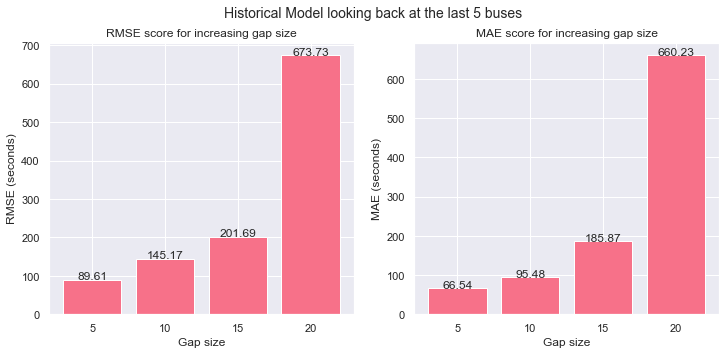

In [456]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

gap_labels = ["5", "10", "15", "20"]

ax[0].bar(gap_labels, rmses_gaps_5b)
ax[0].set_title("RMSE score for increasing gap size")
ax[0].set_xlabel("Gap size")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmseb = [round(rmses_gaps_5b[0], 2), round(rmses_gaps_5b[1], 2), round(rmses_gaps_5b[2], 2), round(rmses_gaps_5b[3], 2)]

for rect, label in zip(rects_rmse, labels_rmseb):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(gap_labels, mapes_gaps_5b)
ax[1].set_title("MAE score for increasing gap size")
ax[1].set_xlabel("Gap size")
ax[1].set_ylabel("MAE (seconds)")

rects_mape = ax[1].patches
labels_mapeb = [round(mapes_gaps_5b[0], 2), round(mapes_gaps_5b[1], 2), round(mapes_gaps_5b[2], 2), round(mapes_gaps_5b[3], 2)]

for rect, label in zip(rects_mape, labels_mapeb):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back at the last 5 buses', fontsize=14)
plt.show()

In [461]:
# avg RMSE and MAE across different gaps

avg_rmse_5b = np.mean(rmses_gaps_5b)
avg_mape_5b = np.mean(mapes_gaps_5b)

print(avg_rmse_5b, avg_mape_5b)

%store avg_rmse_5b avg_mape_5b

277.55049174680937 252.03216217456003
Stored 'avg_rmse_5b' (float64)
Stored 'avg_mape_5b' (float64)


### Putting it all together

The user gives their desired bus stop and bus route and gets a predicted arrival time back.

This would be the algorithm that runs on the mobile app when a user requests the predicted arrival time at a specific stop for a specific route (and direction)

In [151]:
def get_pred_and_actual_arrival_time(route, stop):
    # Will need to do something about inbound or outbound
    weights = {"10": 0.65, "20": 0.18, "40": 0.09, "80": 0.04, "120": 0.02}
    
    df = data[route]

    stop_b_entries = df.loc[(df['bus_stop_name'] == stop) & (df['direction'] == 'inbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    b_stop_index = stops_in_sequence_inbound.get(route).index(stop)
    a_stop_index = b_stop_index - 5 if (b_stop_index - 5) >= 0 else 0 
    a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
    print("{} to {}".format(a_stop_name, stop))
    
    stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
    [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
    
    # req_time = dt.datetime.now()
    req_time = "2020-04-28 08:30:00"
    
    print("Request time is ", req_time)
    
    pred_arr = 0
    
    while pred_arr == 0:
        pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a_entries, stop_b_entries, stop_a_id, weights)
        print("Predicted journey time is ", (pred_jrny_time)/60)
        
        if pred_jrny_time == 0:
            print("Unable to find any journeys")
            pred_arr = 0
        else:
            pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a_entries, pred_jrny_time, most_recent_left)

        if pred_arr == 0:
            print("Couldn't find correlating leaving bus, go back 1 more stop")
            a_stop_index = a_stop_index - 1

            if a_stop_index < 0:
                print("No journeys found on entire route")
                return 0, 0

            a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
            stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
            [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
            print("{} to {}".format(a_stop_name, stop))

    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr = get_actual_times(stop_b_entries, req_time, bus_to_track, stop_b_id)
    
    if actual_arr is None:
        print("There is no bus arriving at req_time")
        return pred_arr, 0
    
    return pred_arr, actual_arr

In [152]:
user_route = "9"
user_stop = "Royal Albert Hall"

start = time.time()
predicted_arr_time, actual_arr_time = get_pred_and_actual_arrival_time(user_route, user_stop)
print("Total time ", (time.time() - start))

Phillimore Gardens to Royal Albert Hall
Request time is  2020-04-28 08:30:00
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  74
Number of buses that have feasible journey times:  13
Predicted journey time is  4.358983451536642
There are no buses due at this time from this stop
Couldn't find correlating leaving bus, go back 1 more stop
The Design Museum to Royal Albert Hall
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  72
Number of buses that have feasible journey times:  12
Predicted journey time is  4.76060606060606
There are no buses due at this time from this stop
Couldn't find correlating leaving bus, go back 1 more stop
Warwick Gardens to Royal Albert Hall
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times: